In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.decomposition import PCA
import pickle
from tqdm.notebook import tqdm

In [2]:
#Reading the dataset

population_data_raw = pd.read_csv('./Data/population.csv') #will be referring to this as Dataset-1
more_than_50_raw = pd.read_csv('./Data/more_than_50k.csv') #will be referring to this as Dataset-2

# population_data_raw 

Step 1 : Preprocessing

In [3]:
def preprocessing(df):
    ''' Input: df - The Pandas dataframe to be preprocessed
        Returns: a pandas dataframe which contains the preprocessed data(preprocessing steps according to Part1)
    '''

    #replace ? with Nan
    df = df.replace({' ?' :  np.nan})

    #drop columns with more than 40% NaN values
    cols = df.columns
    missing_percentages = (df.isna().sum() / len(df)) * 100 #Calculating missing percentages for each column
    cols_to_drop = []
    for col in cols:
        if(missing_percentages[col] > 40.0): #checking if a column has more than 40% missing data
            cols_to_drop.append(col)
    print(f'Dropping = {cols_to_drop}')
    df = df.drop(cols_to_drop, axis=1) #dropping the columns
    return df

In [4]:
data = preprocessing(population_data_raw) #performing step-1 on Dataset-1
print(data.shape)

Dropping = ['MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN']
(199523, 36)


In [5]:
data_more_than_50 = preprocessing(more_than_50_raw) #performing step-1 on Dataset-2
print(data_more_than_50.shape)

Dropping = ['MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN']
(3580, 36)


Step 2 : Feature Analysis

In [6]:
def plot_histogram(df, numeric_columns, anum):
    ''' This function is used to plot histogram for the columns of the passed DataFrame df. Numeric columns of the dataframe are also passed.
        anum - Just denotes the dataset number (1 or 2) {used for personal reference}
    '''
    features = df.columns
    for feat in features: #for all features, plot histogram
        plt.figure(figsize=(25, 5))
        if(feat in numeric_columns): #if the column is numeric, we specify 6 bins
            df[feat].astype(str).hist(bins=6, edgecolor='black', linewidth=1.8)
        else:
            unique_cat_values = len(df[feat].unique()) #else, bins = no. of distinct categories in categorical columns
            df[feat].astype(str).hist(bins = unique_cat_values, edgecolor='black', linewidth=1.8)
        plt.xlabel(feat)
        plt.ylabel('Count')
        plt.title(f'{anum} : Histogram - {feat}')
        plt.savefig(f'./Plots/Histograms/{feat}_{anum}', facecolor='w', bbox_inches='tight')
        plt.show()

In [7]:
def feature_analysis(df, anum):
    '''
        Takes input dataframe to perform the feature analysis part (step2). anum - Just denotes the dataset number (1 or 2)
    '''

    
    numeric_columns = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'WKSWORK'] #the numeric columns in the datasets as per the description
    df_copy = df.copy(deep=True) 
    
    for col in numeric_columns:
        df_copy[col] = pd.cut(x=df_copy[col], bins=6) #cutting the numeric columns of a copy just for the sake of plotting histogram

    #2.1
    plot_histogram(df_copy, numeric_columns, anum) #plotting histogram

    #2.2
    total_count = df_copy.shape[0]
    cols_to_drop = []

    for col in df_copy.columns: #through this loop we check that if any one particular value dominates with more than 80% in a particular column, we remove that column.
        max_freq = df_copy[col].value_counts().max()
        max_perc = (max_freq / total_count) * 100
        if(max_perc > 80.0):
            cols_to_drop.append(col)
    # print(f'{anum} : Dropping {len(cols_to_drop)} cols \n {cols_to_drop}')
    df = df.drop(cols_to_drop, axis=1)
    return df


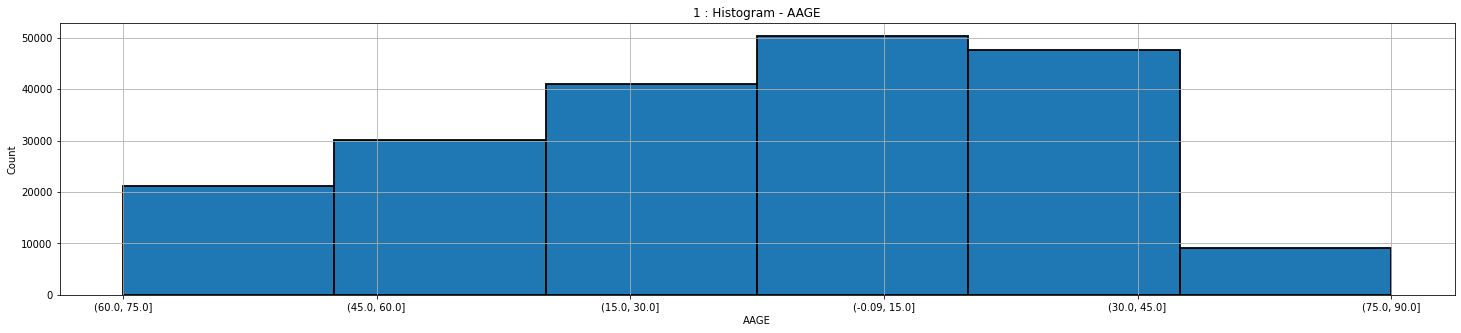

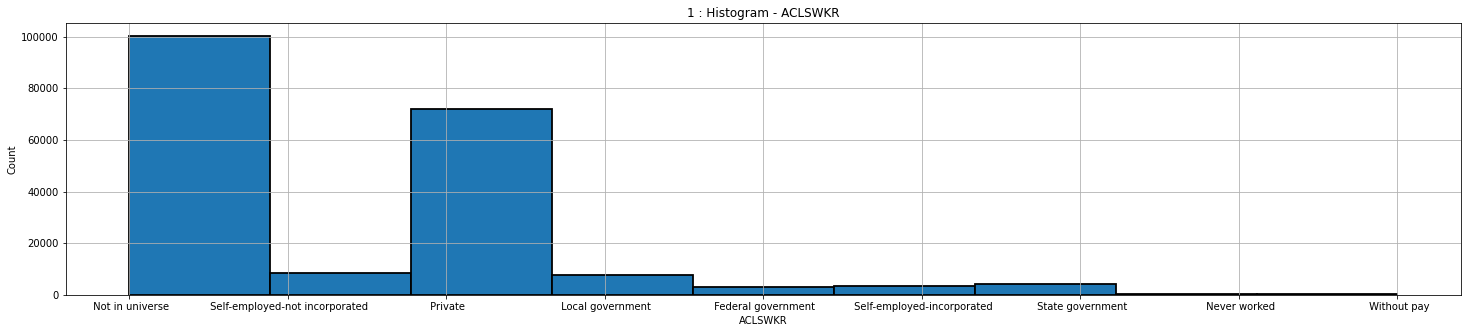

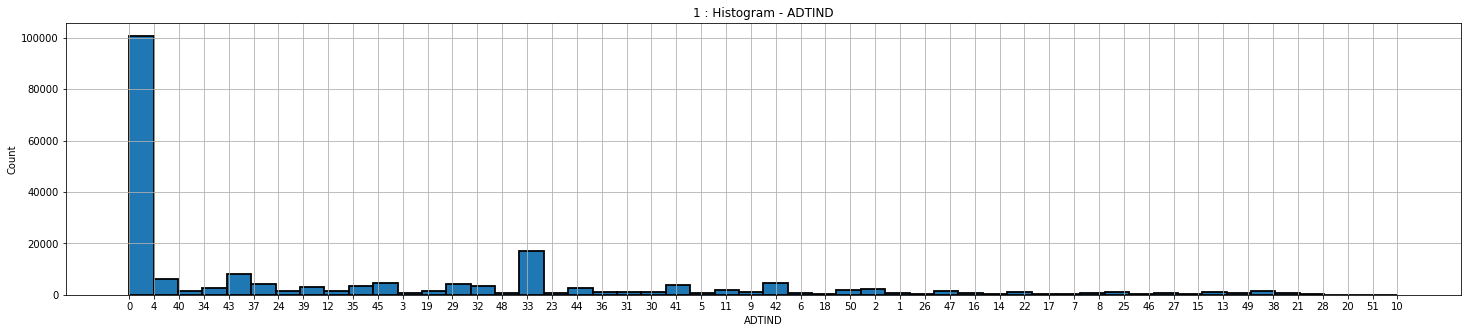

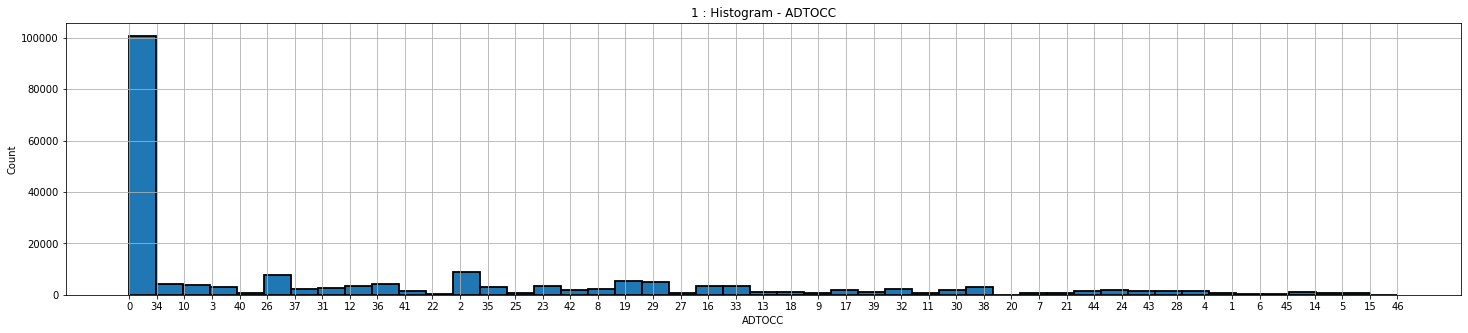

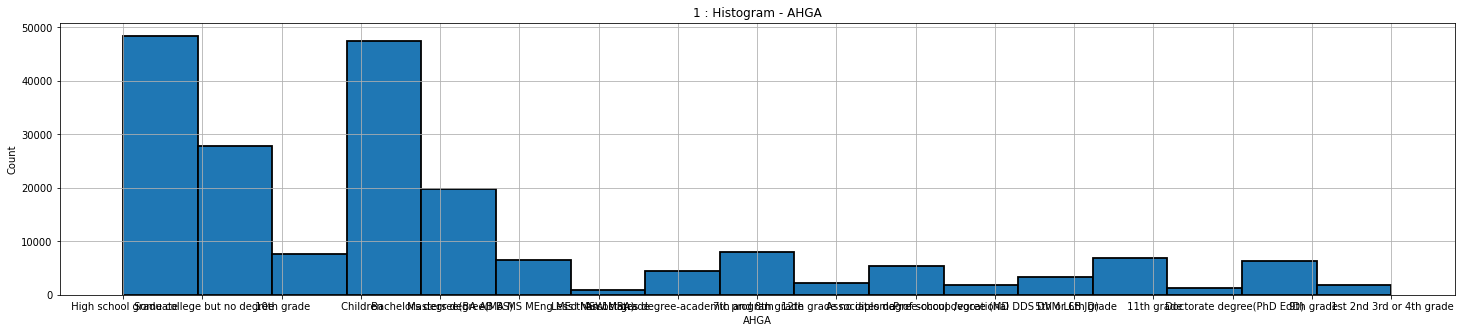

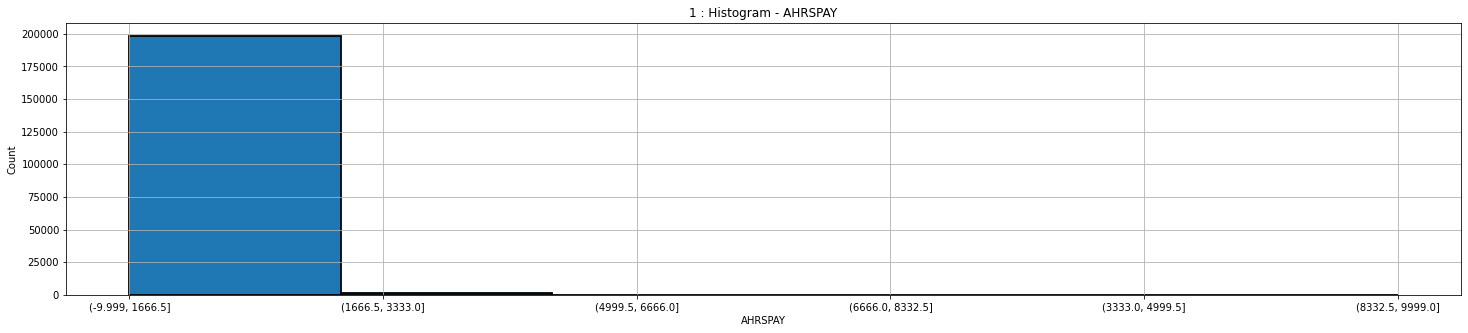

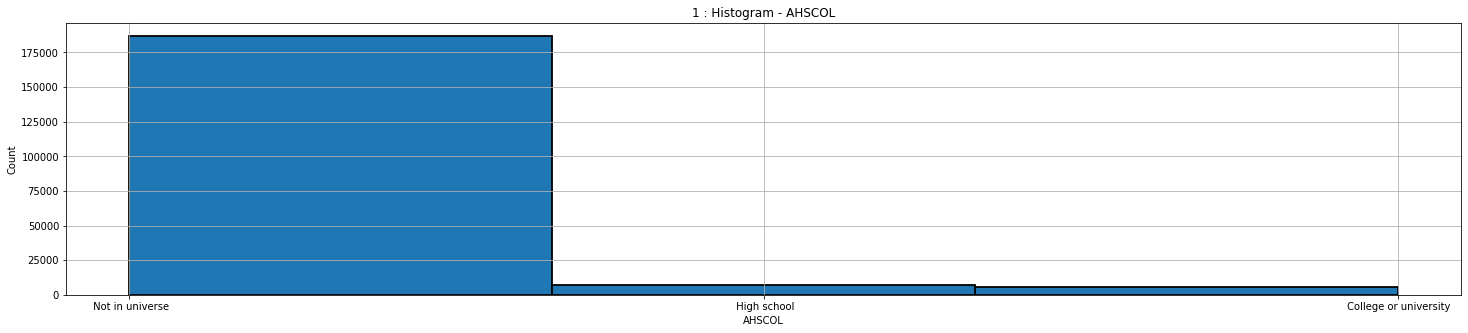

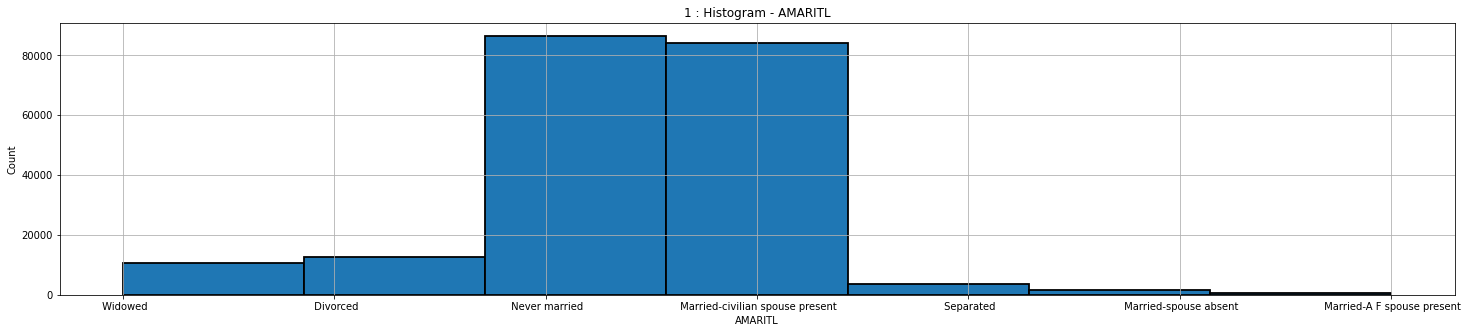

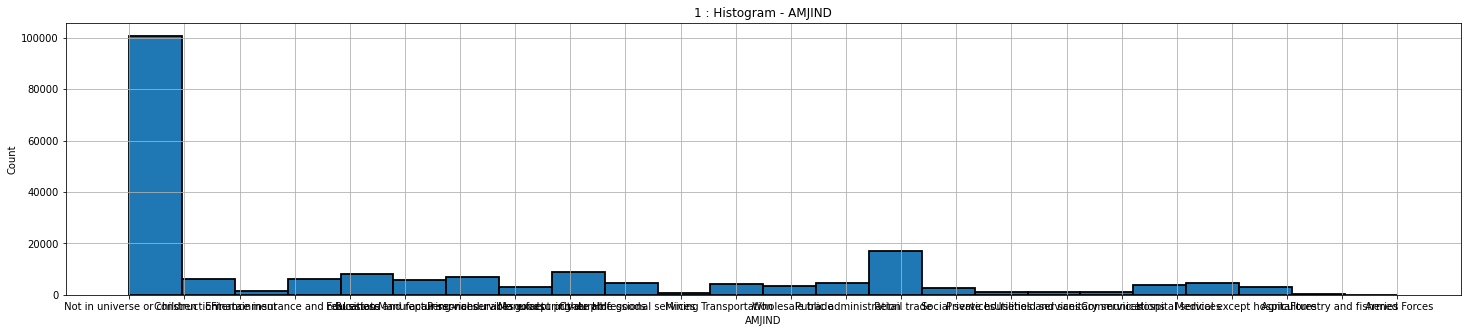

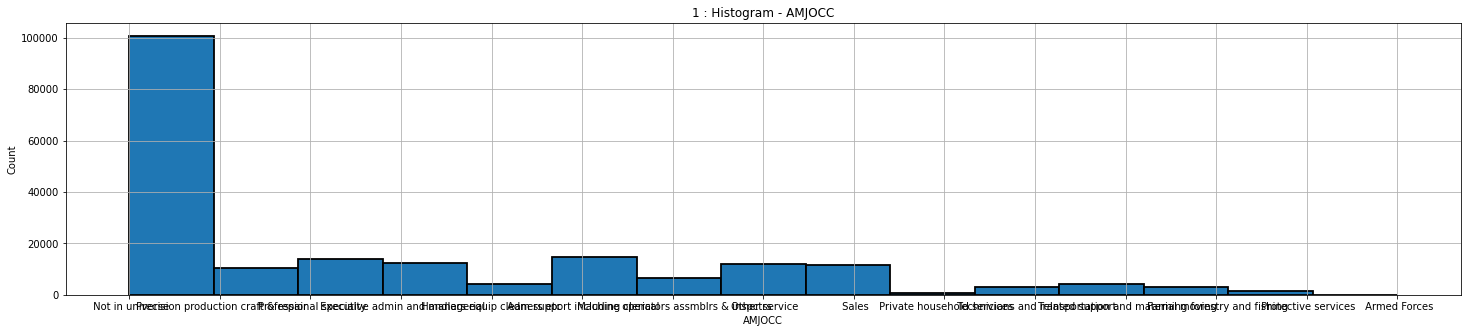

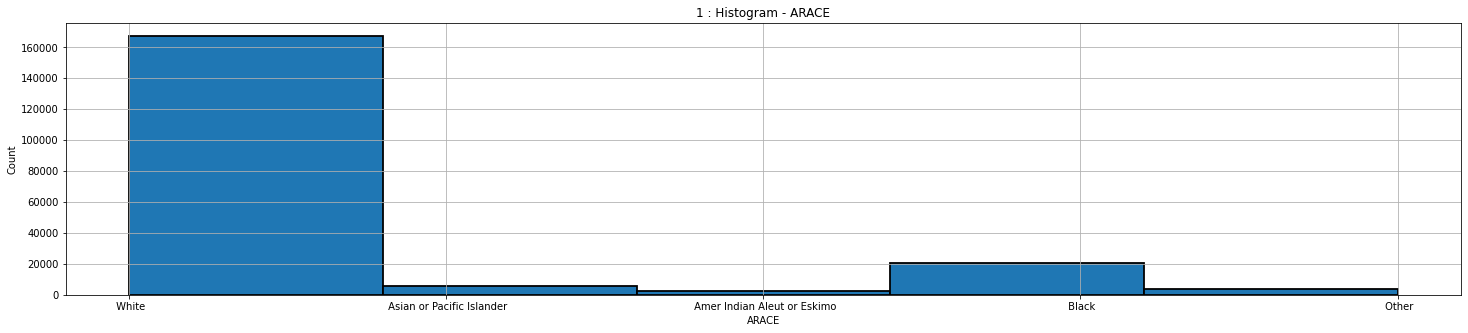

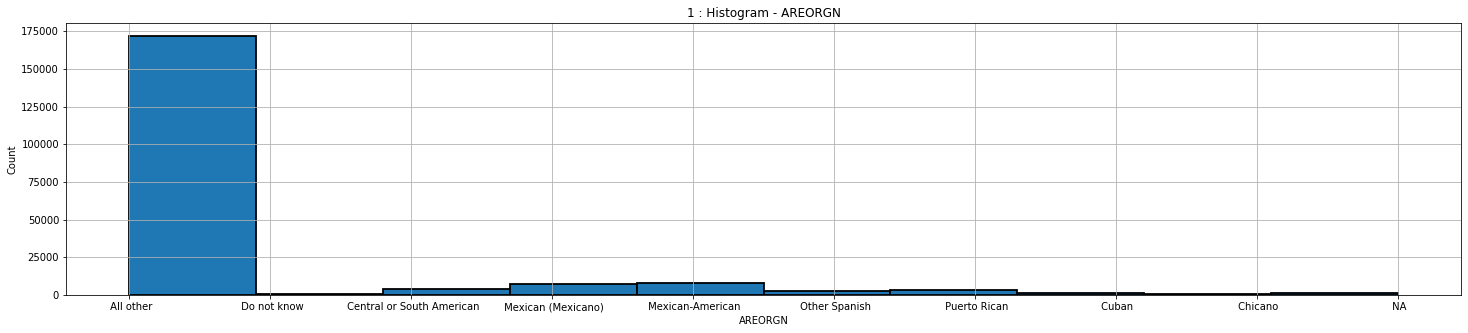

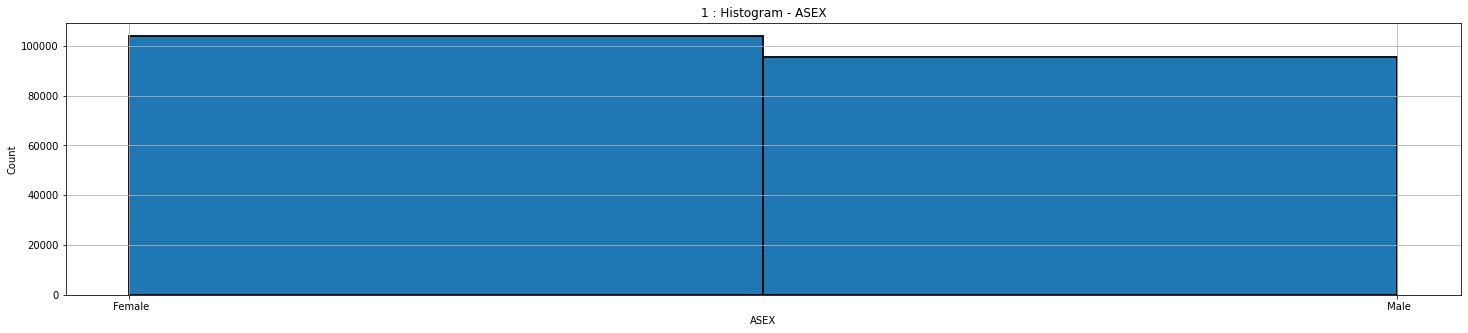

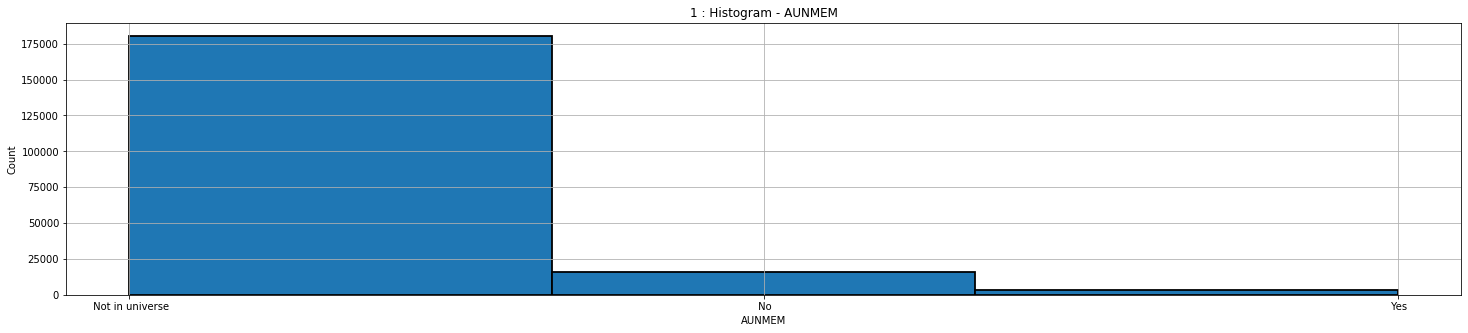

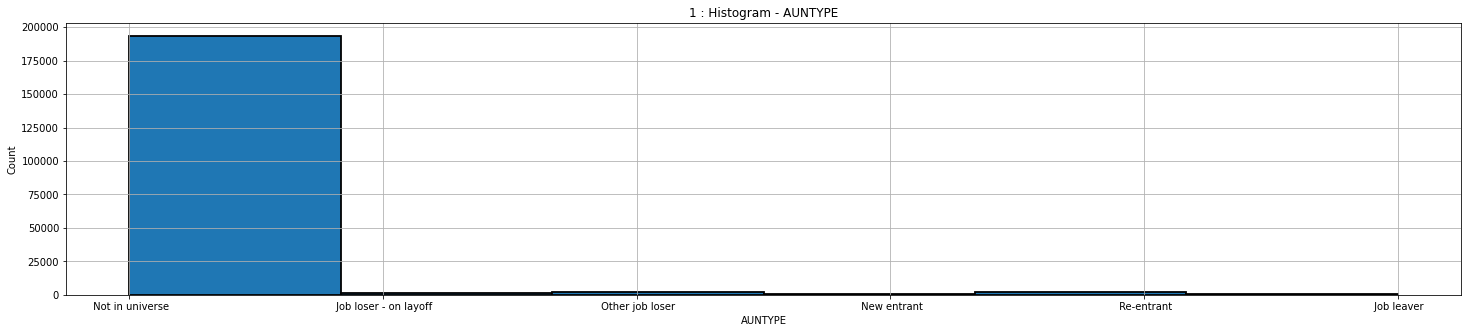

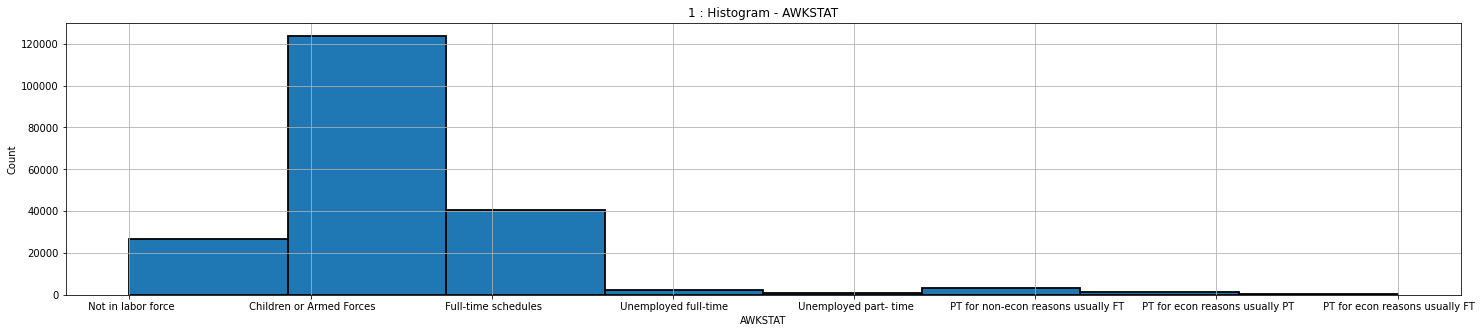

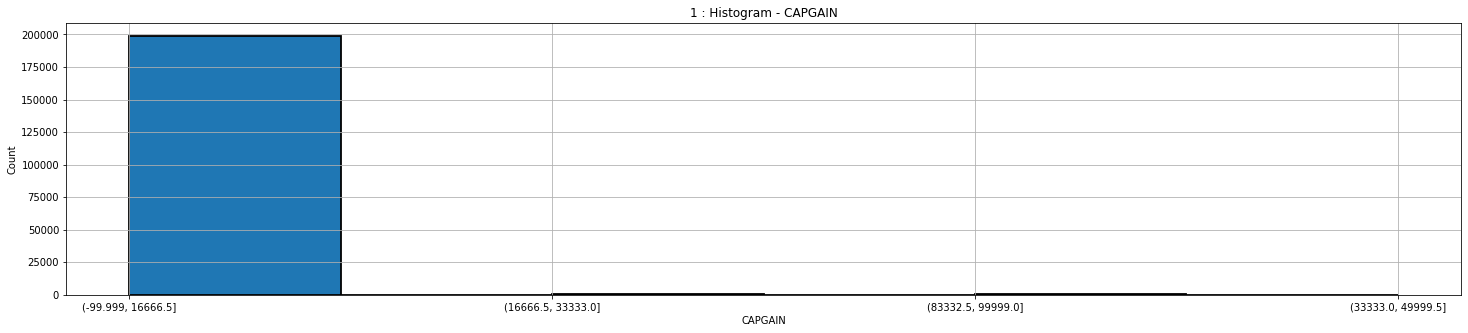

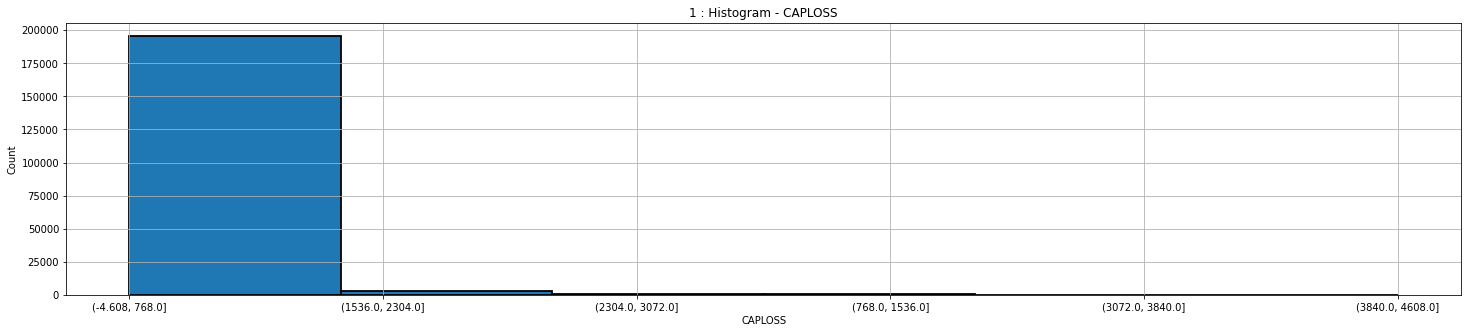

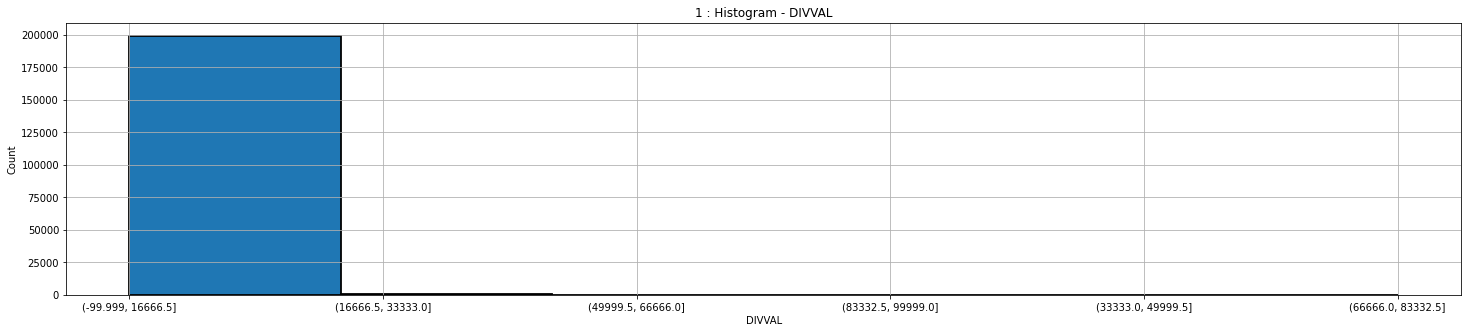

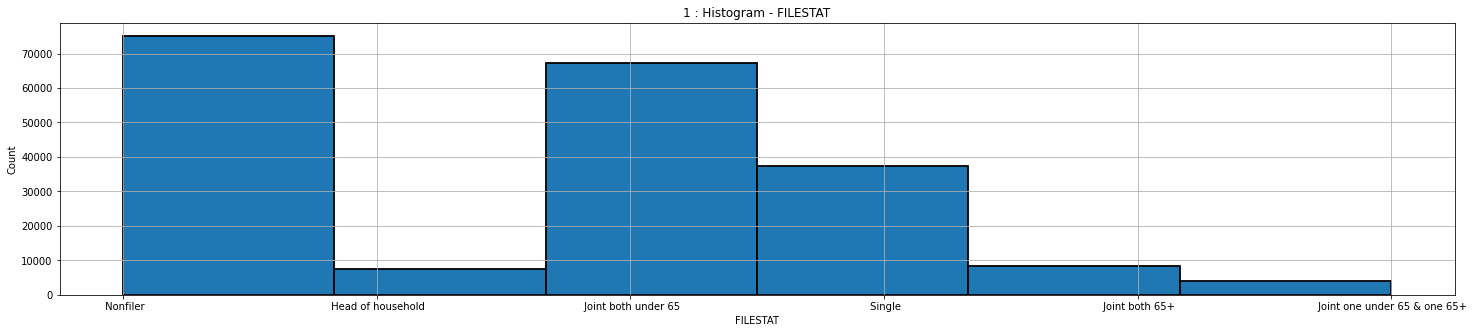

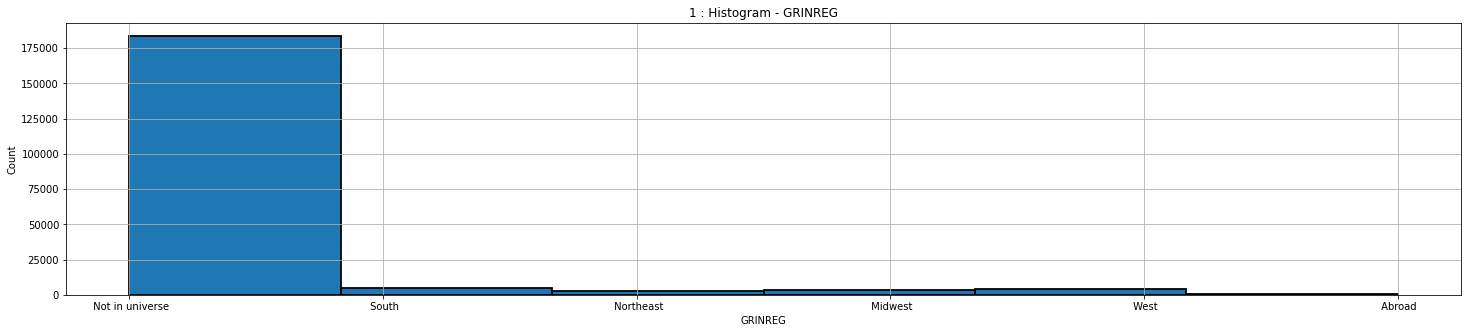

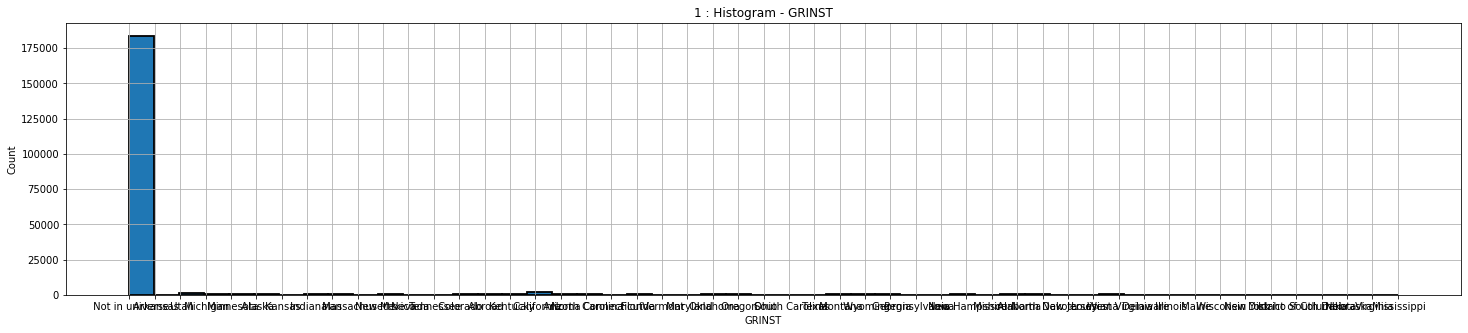

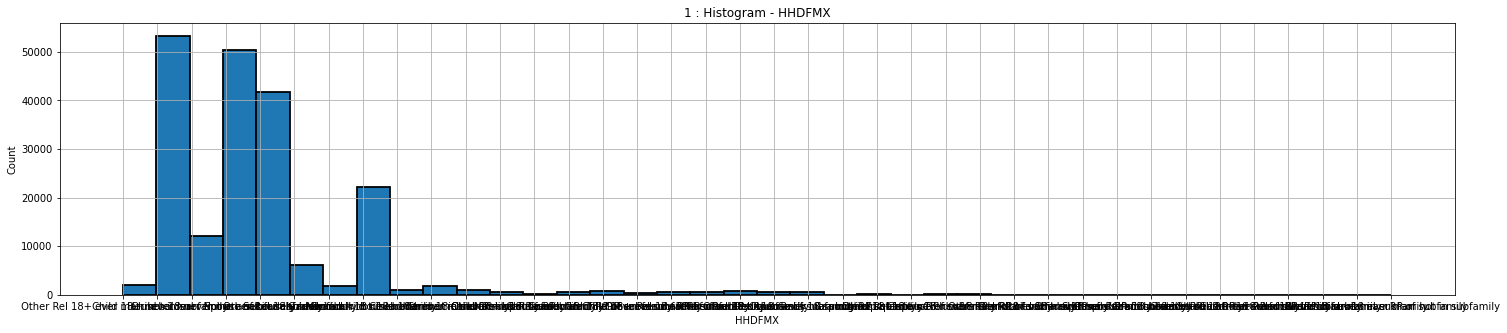

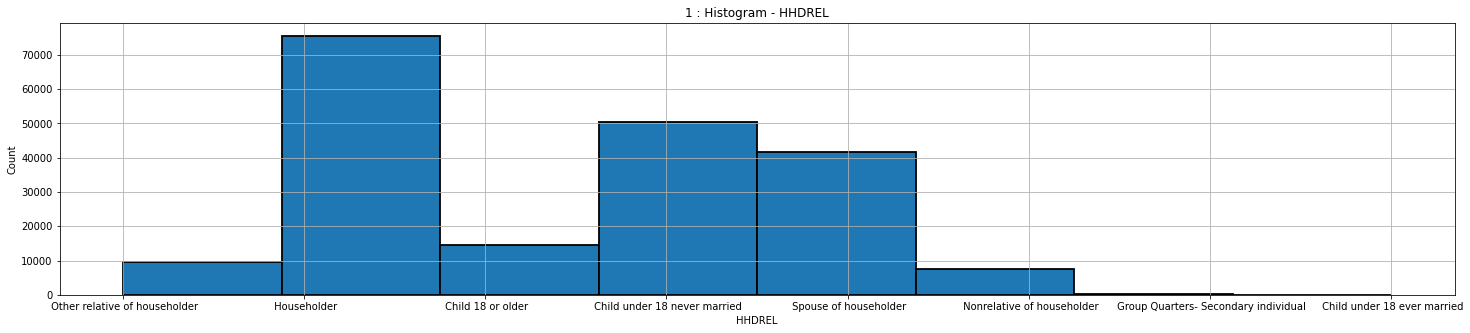

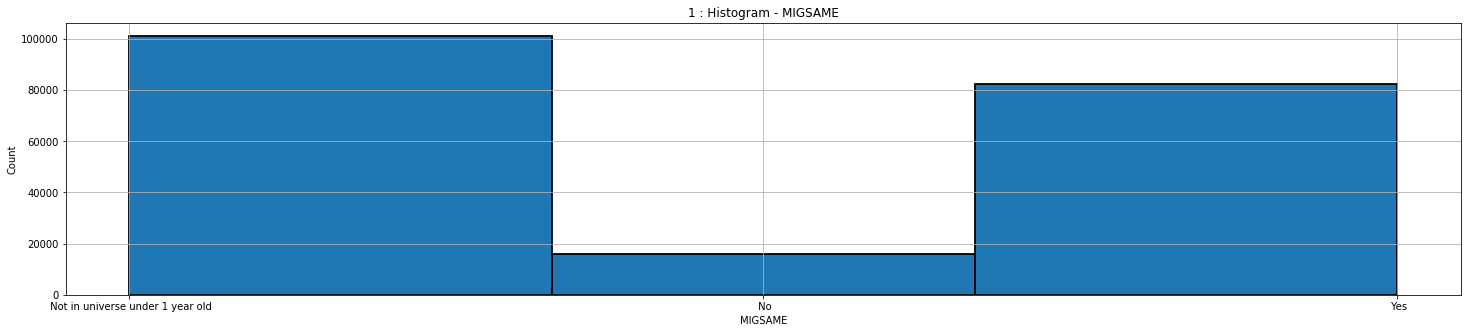

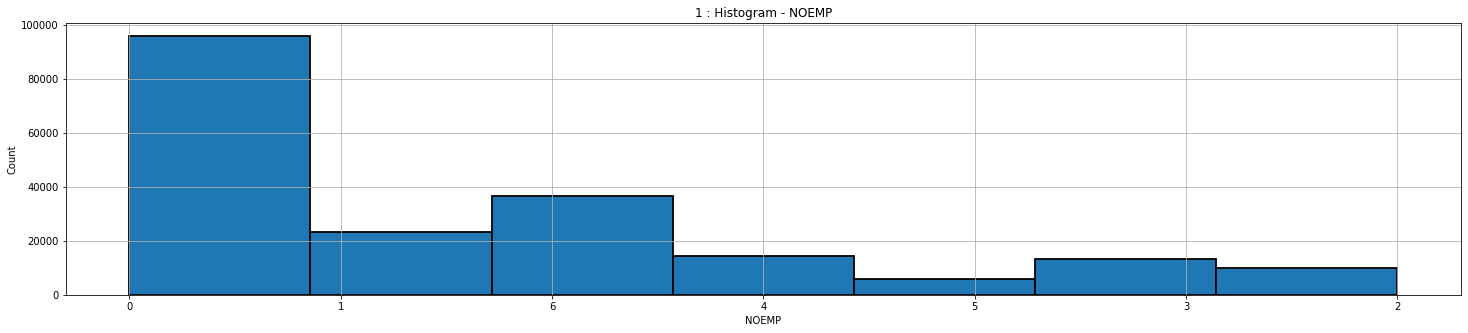

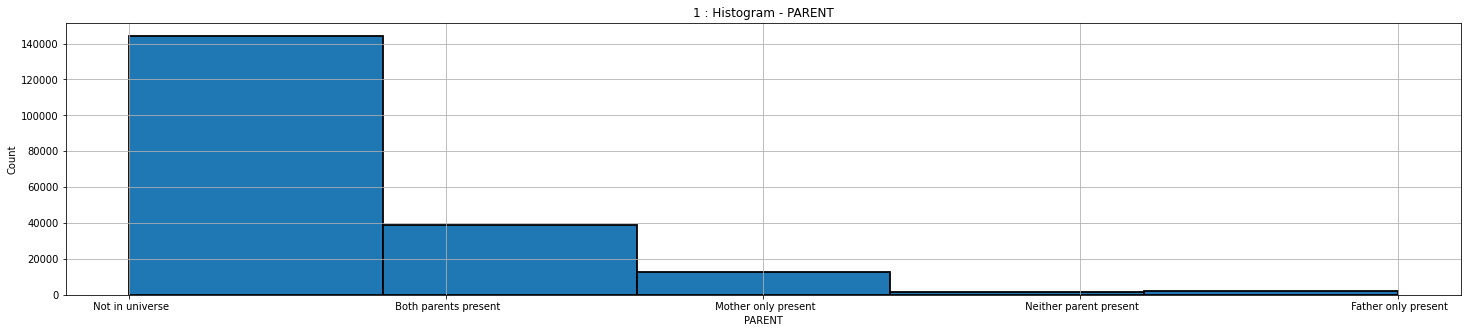

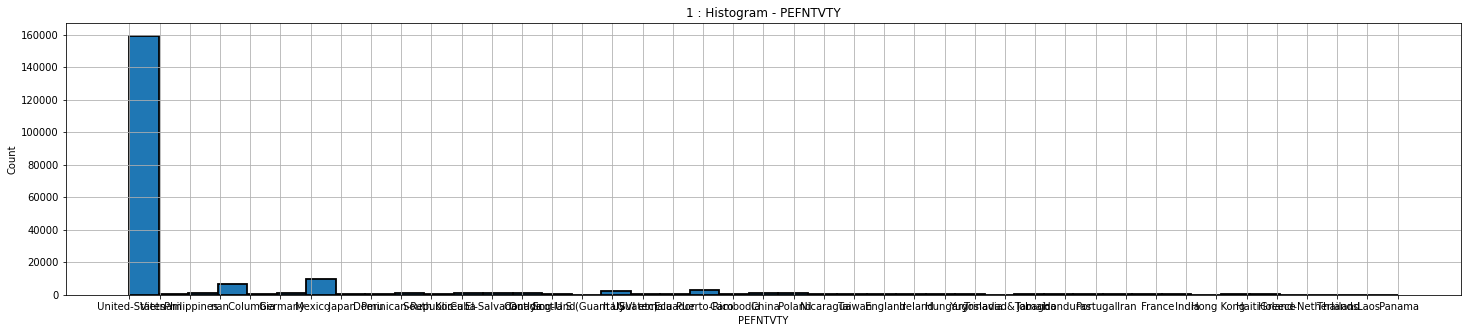

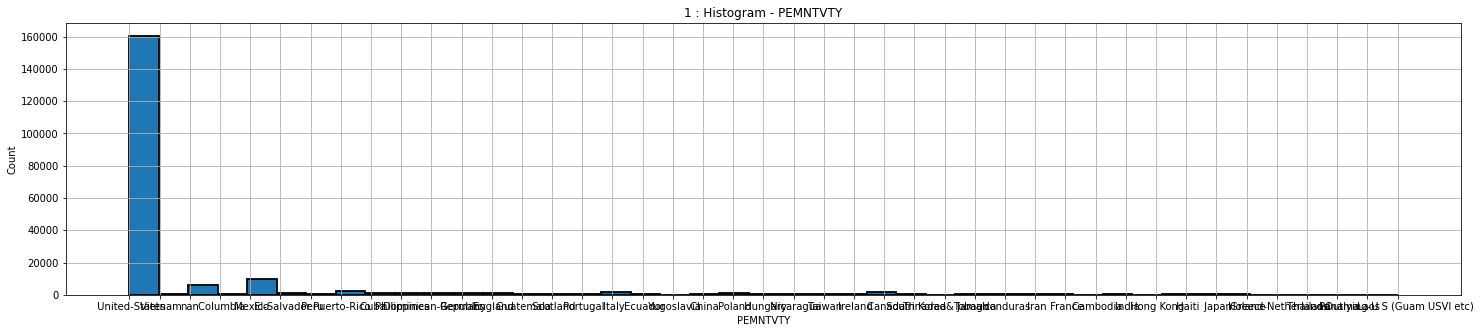

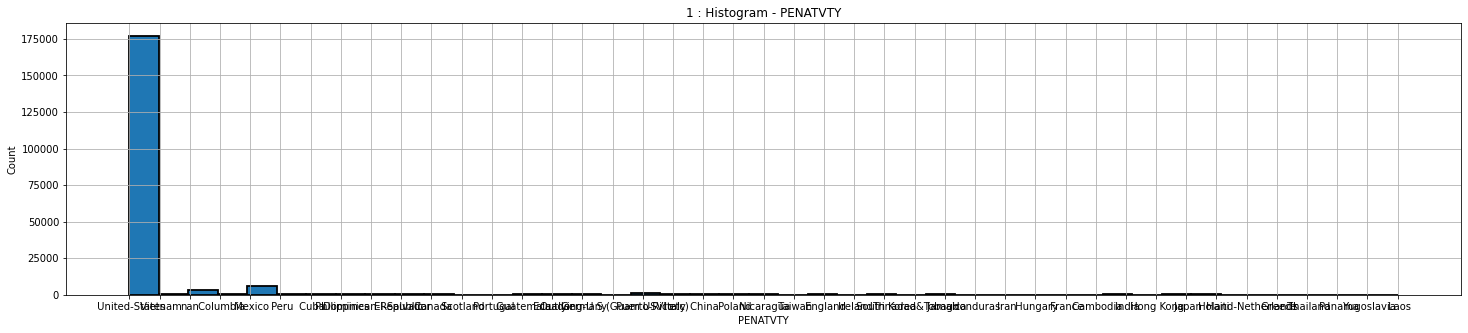

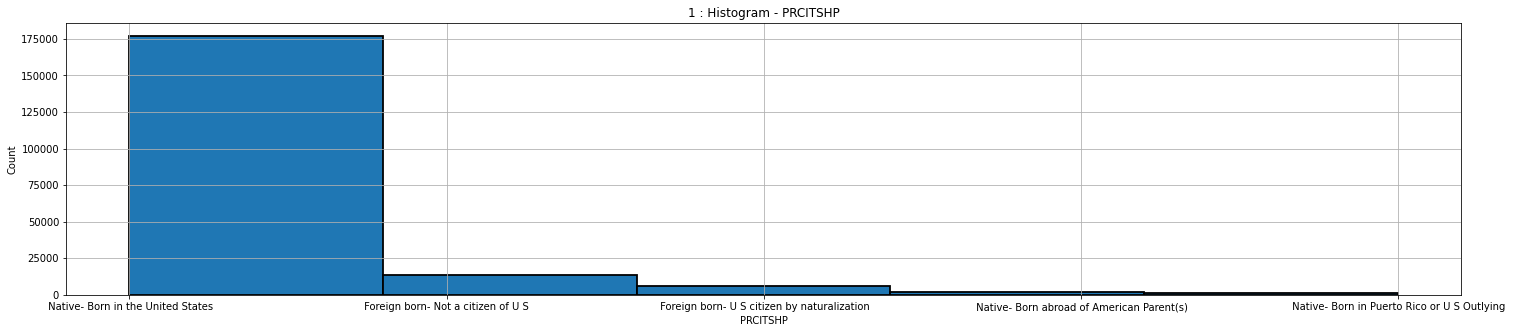

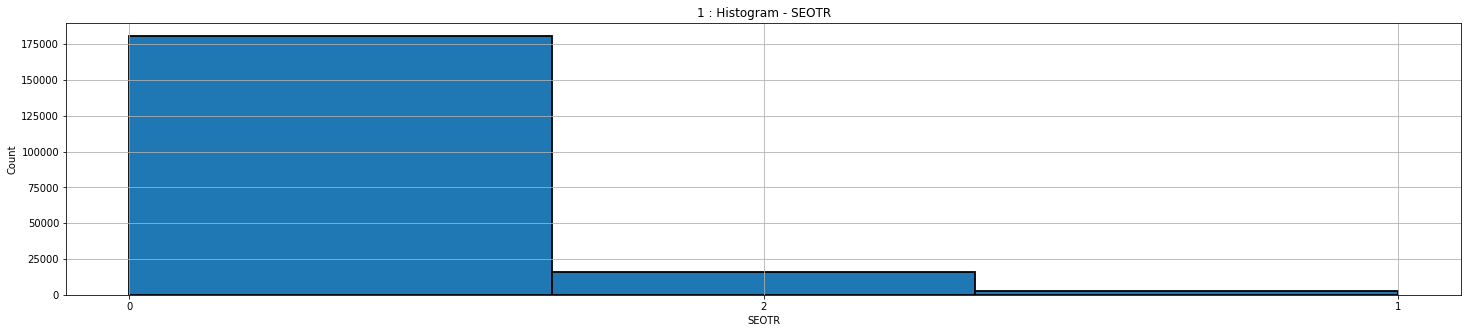

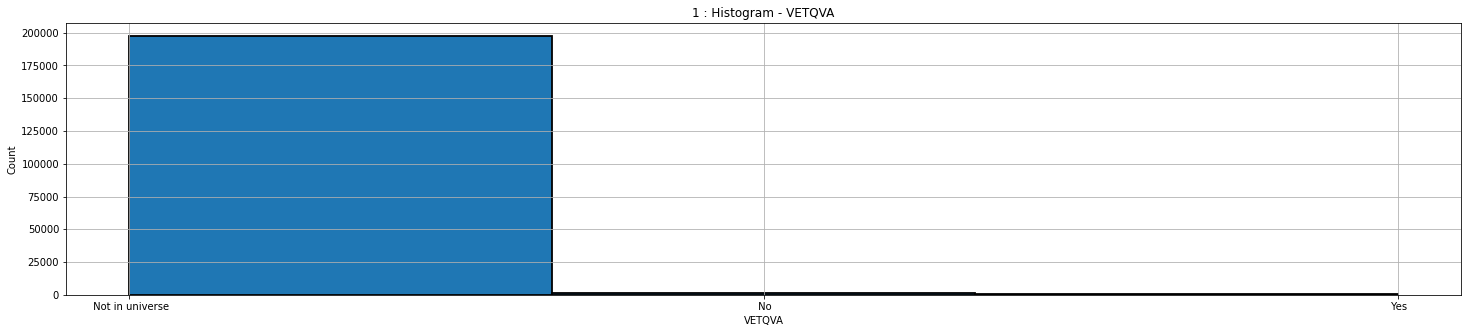

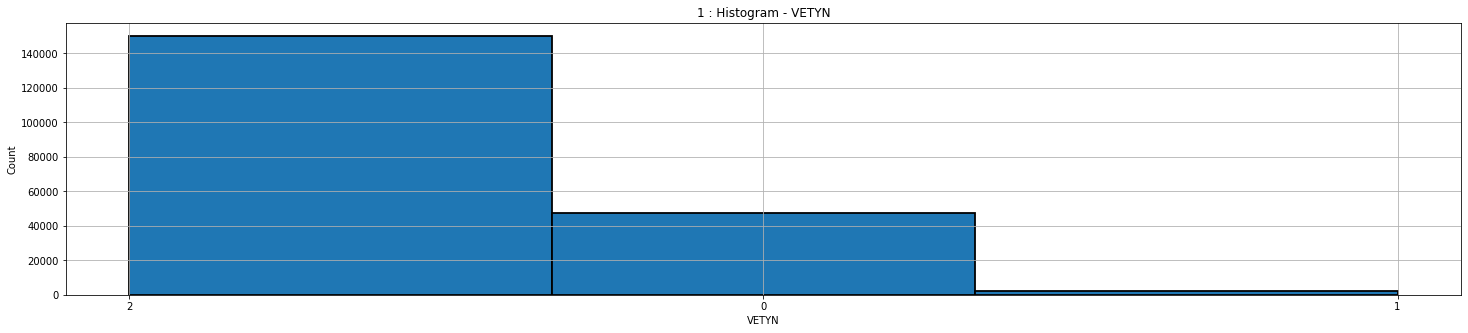

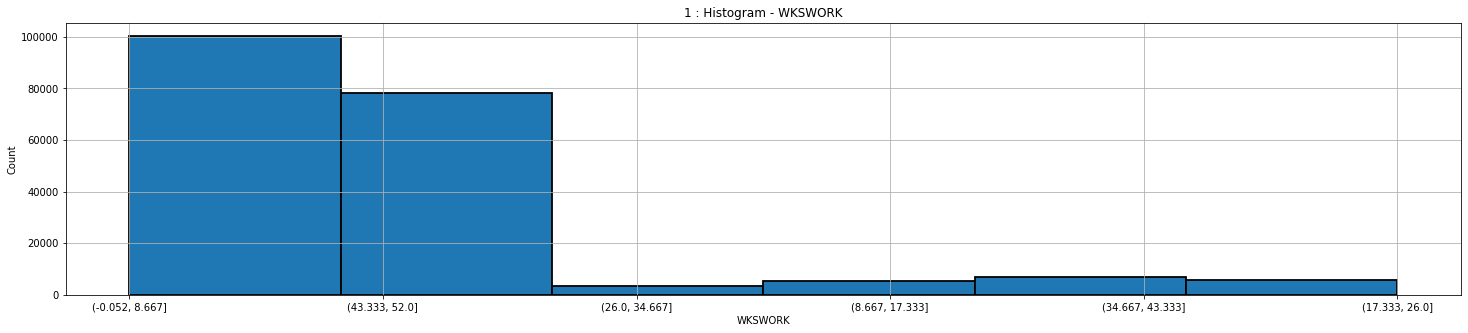

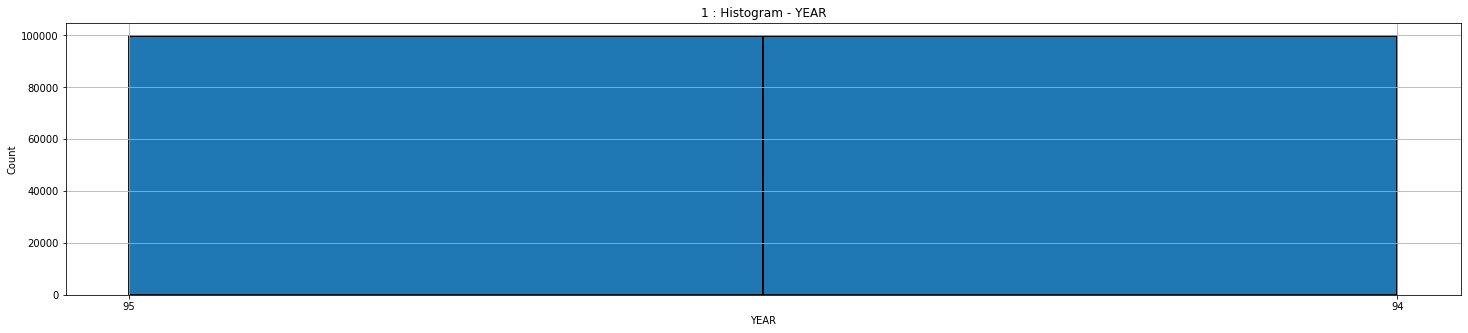

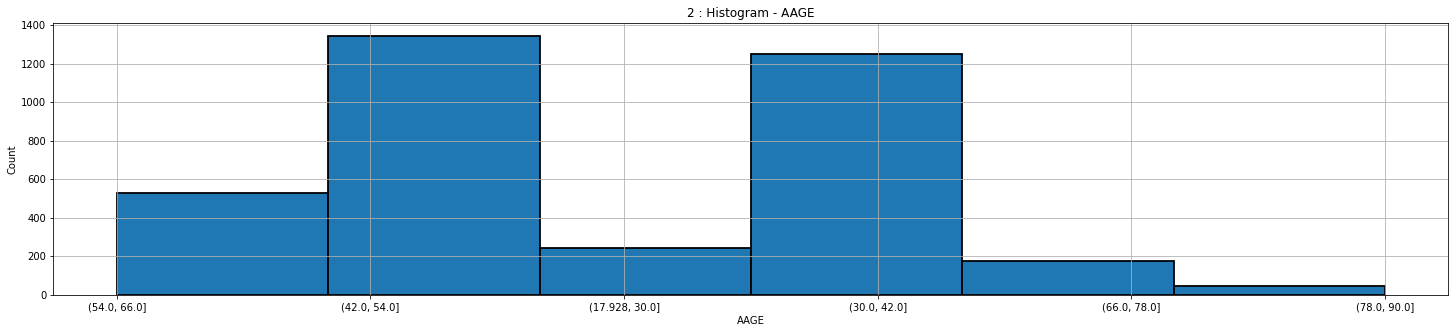

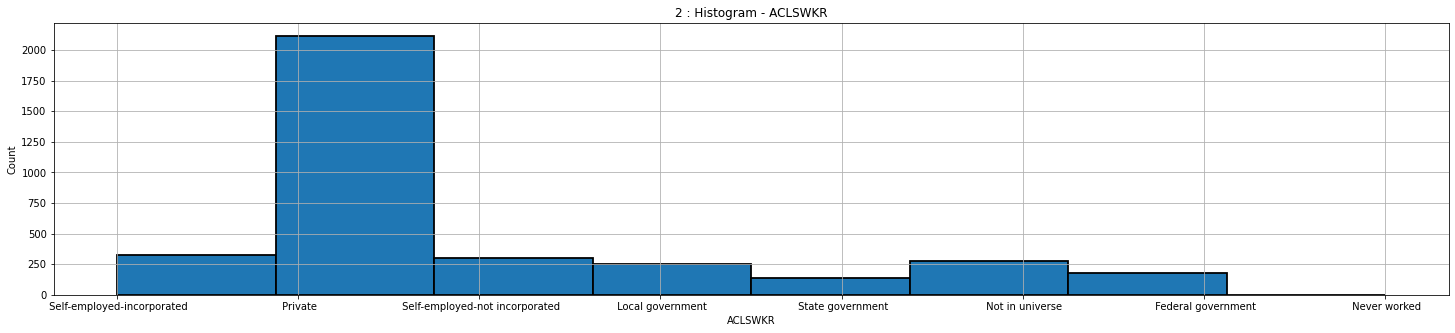

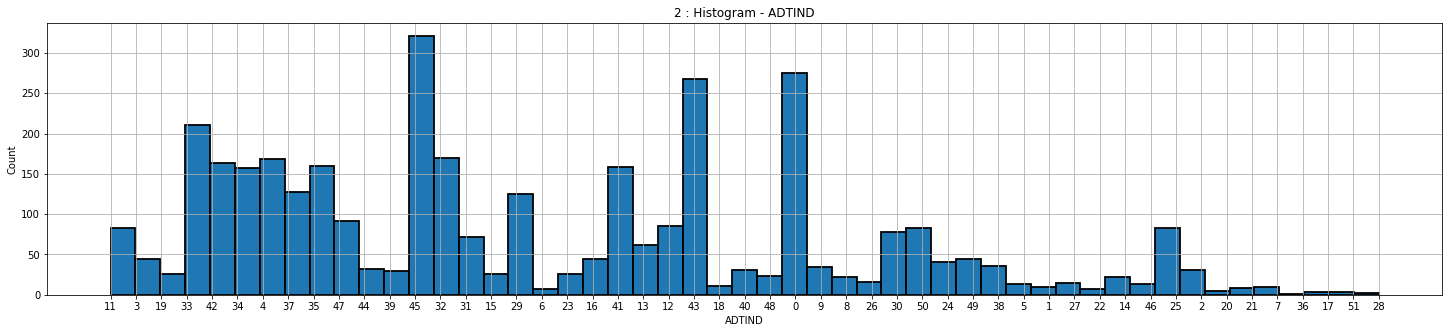

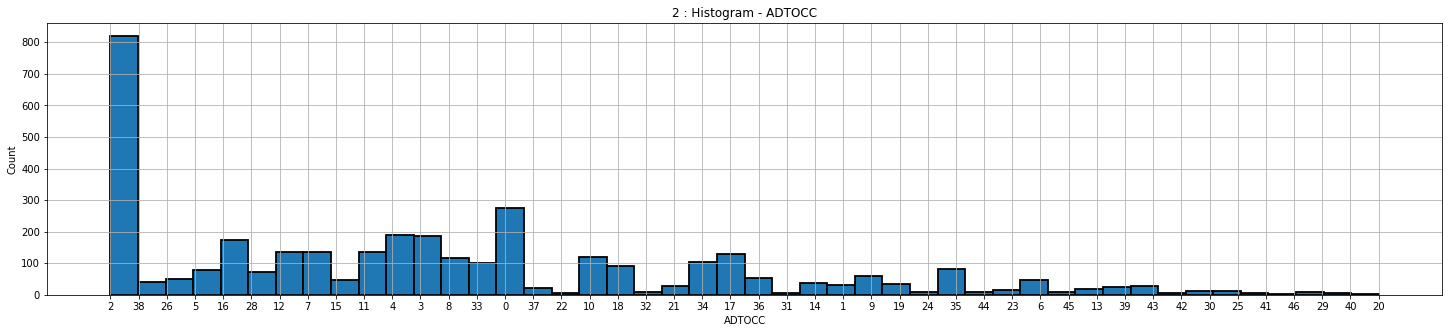

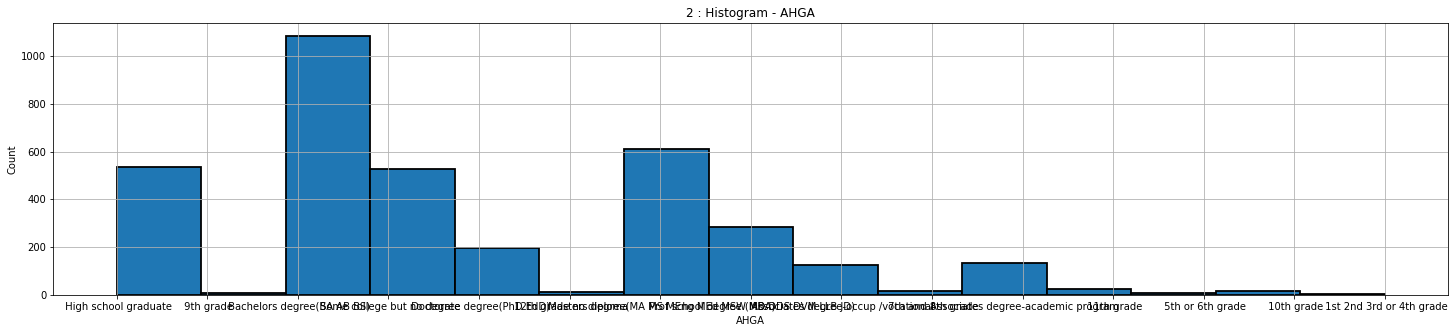

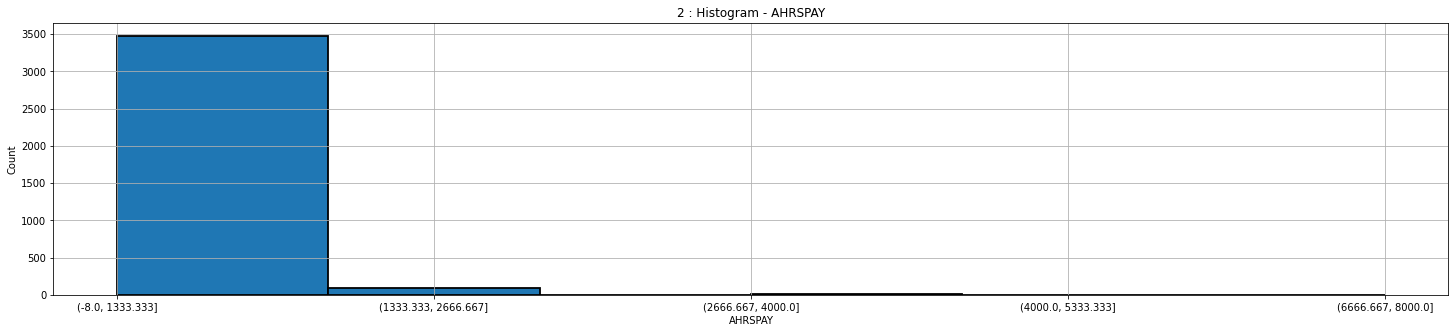

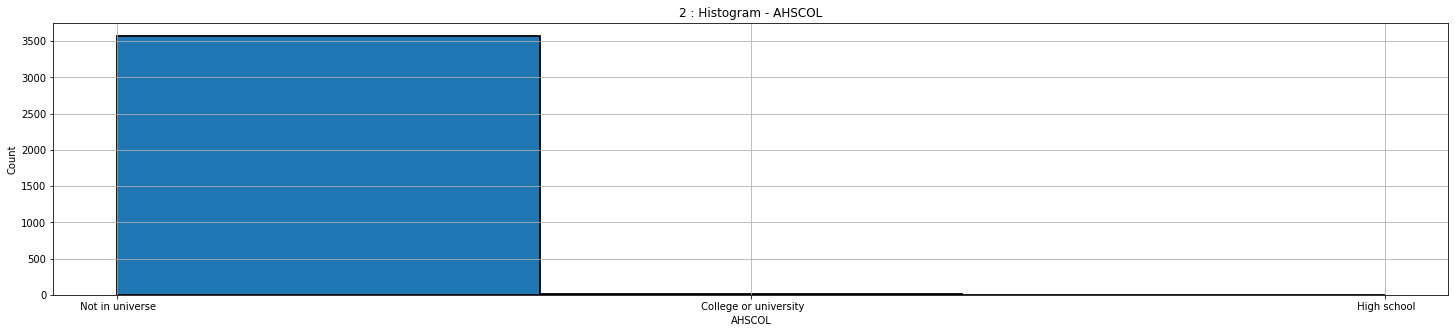

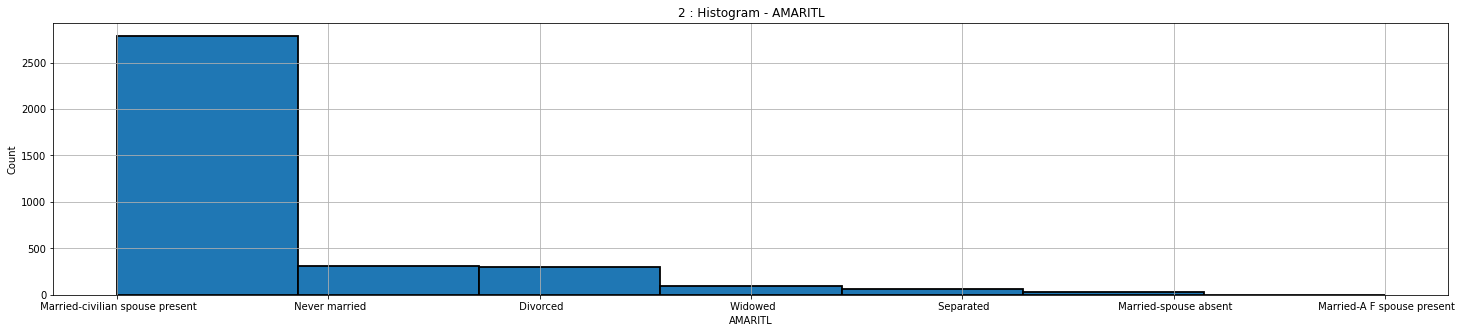

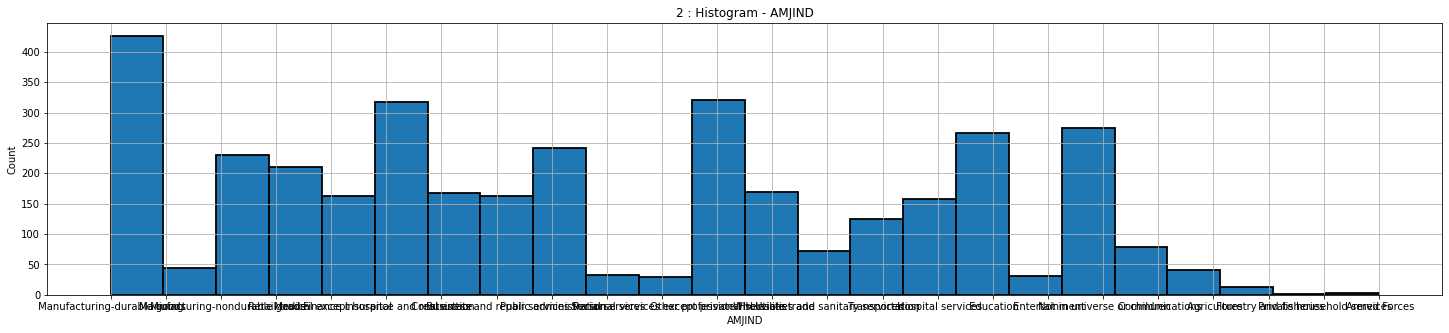

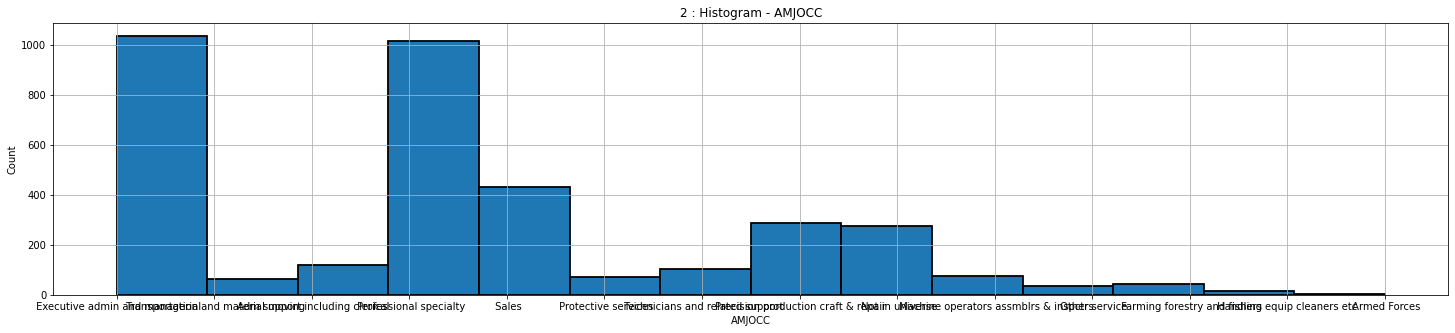

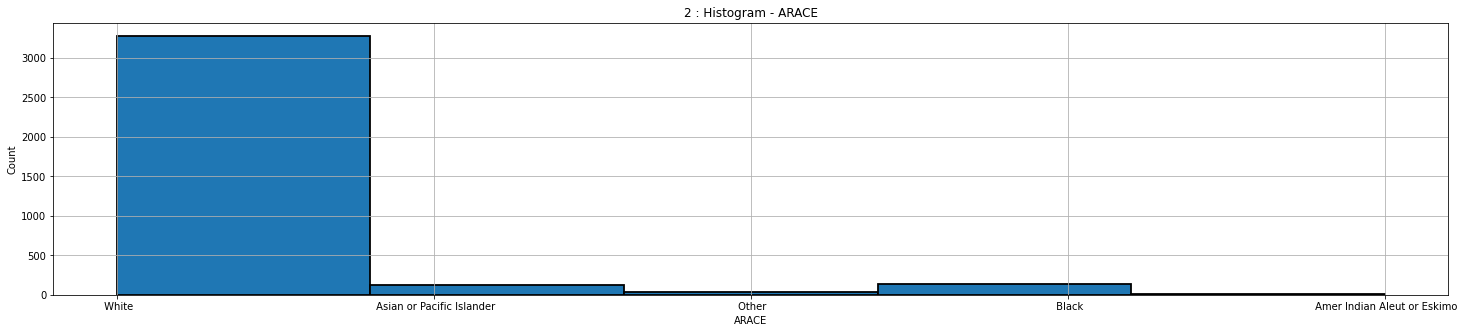

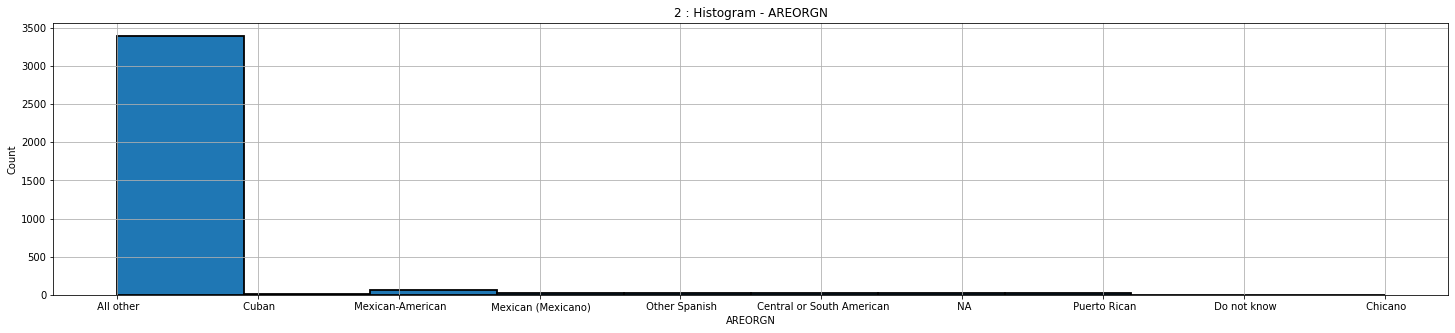

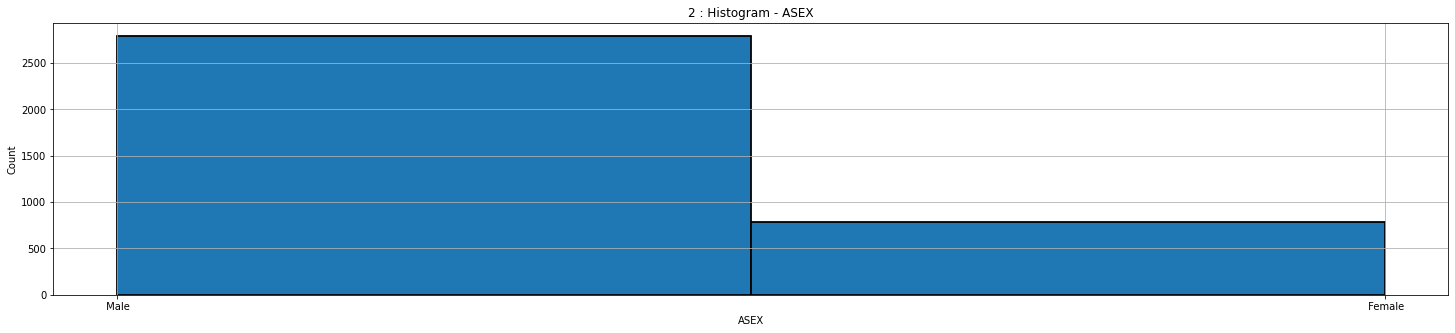

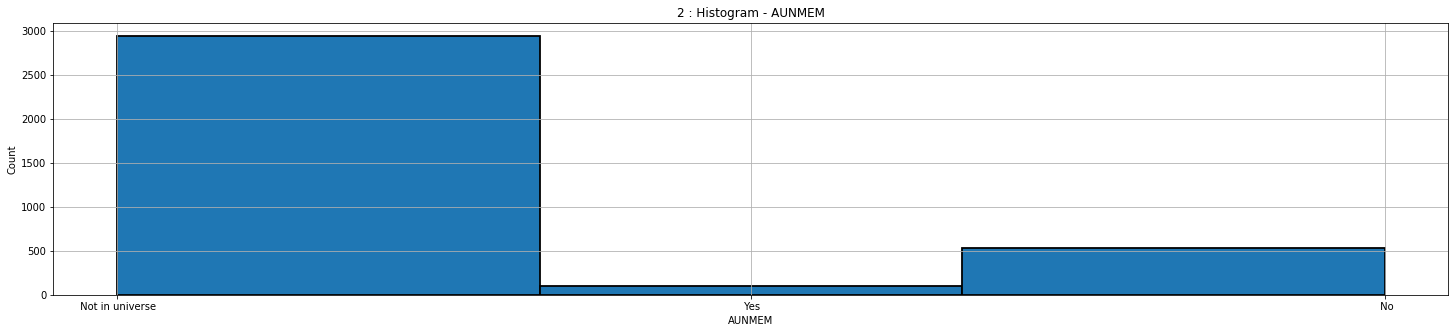

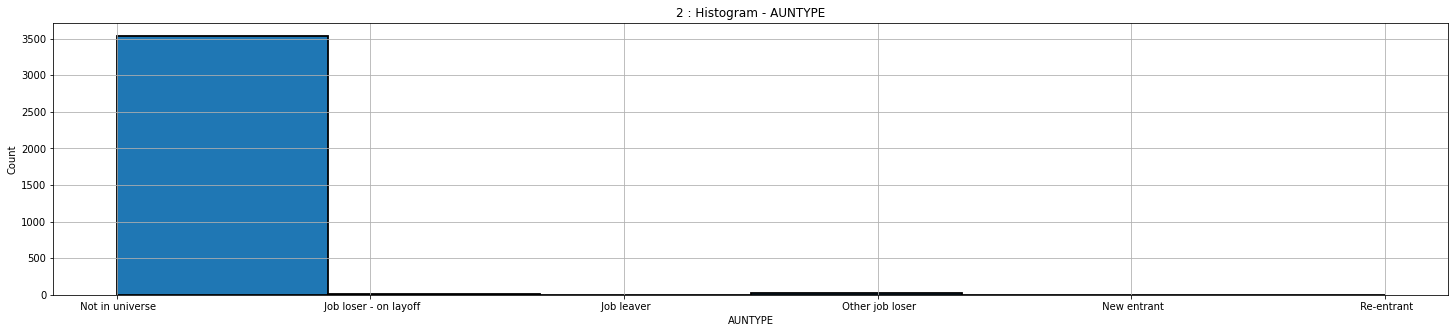

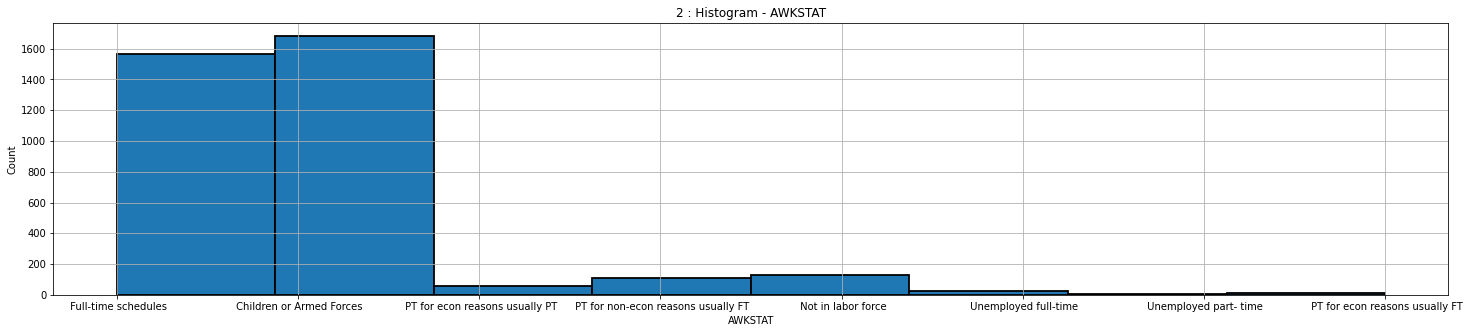

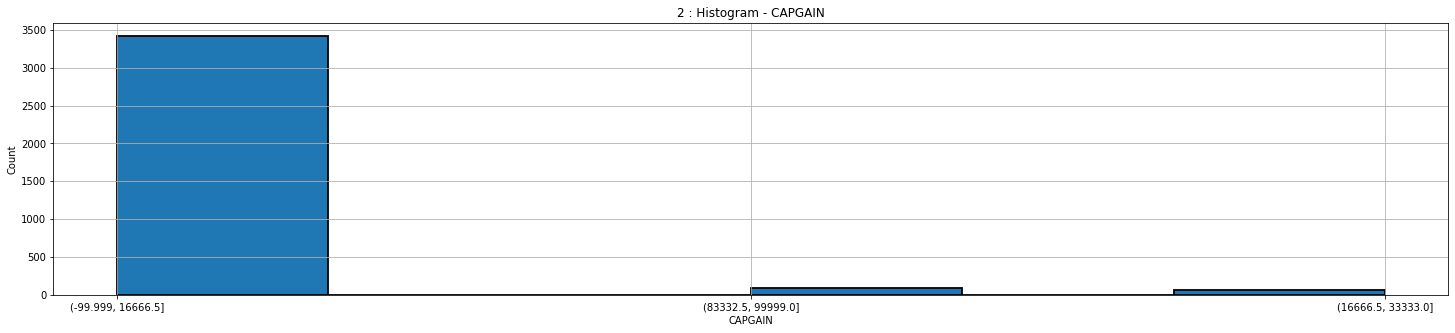

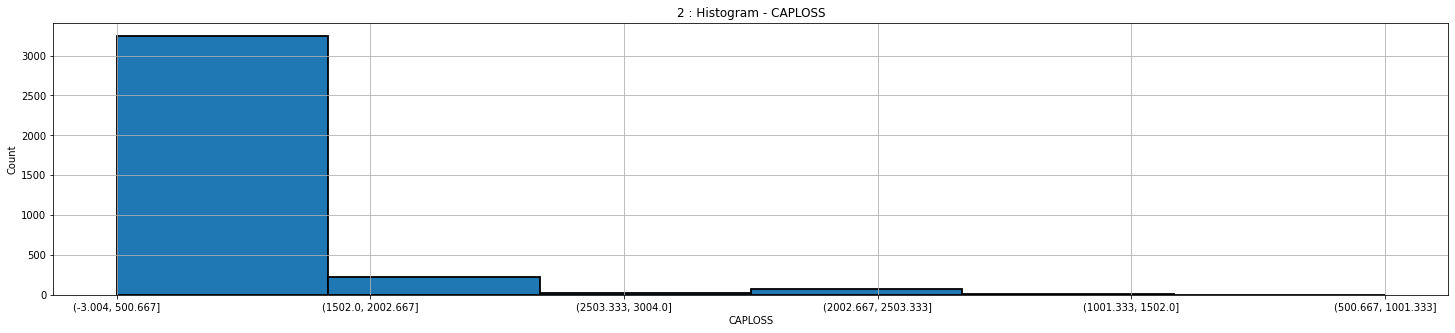

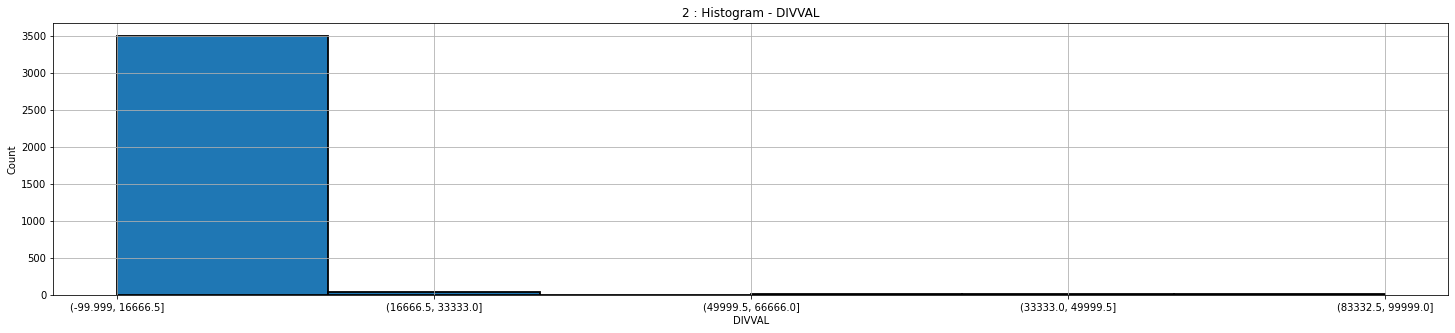

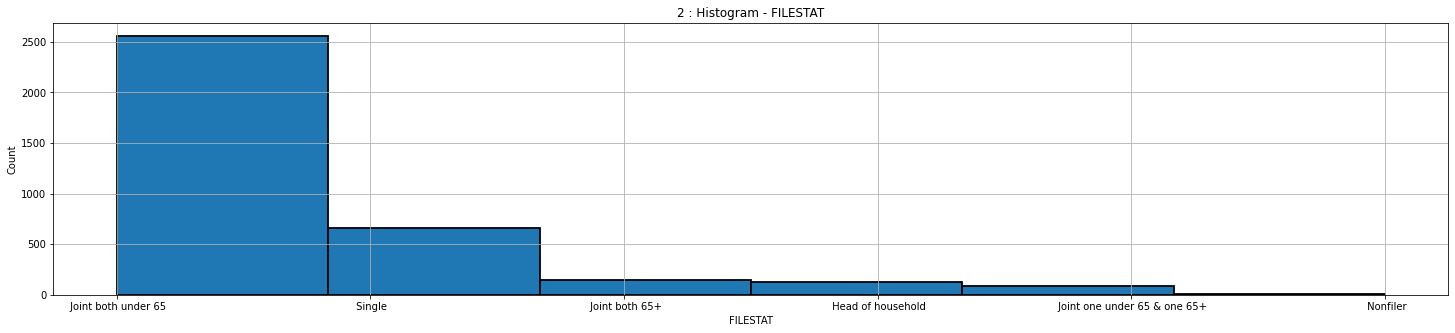

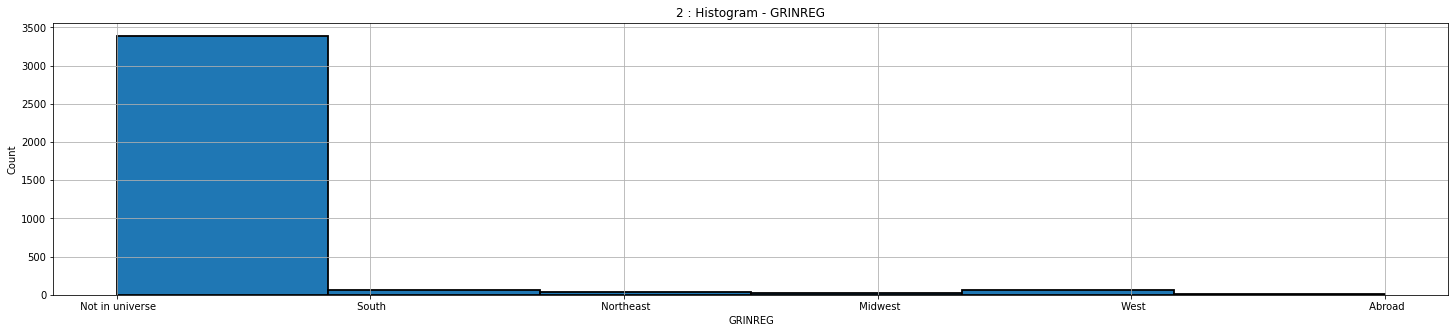

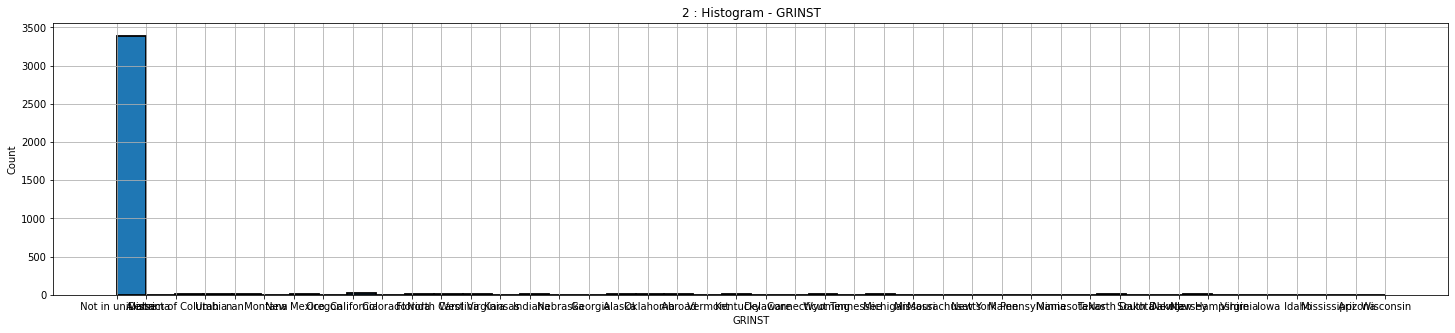

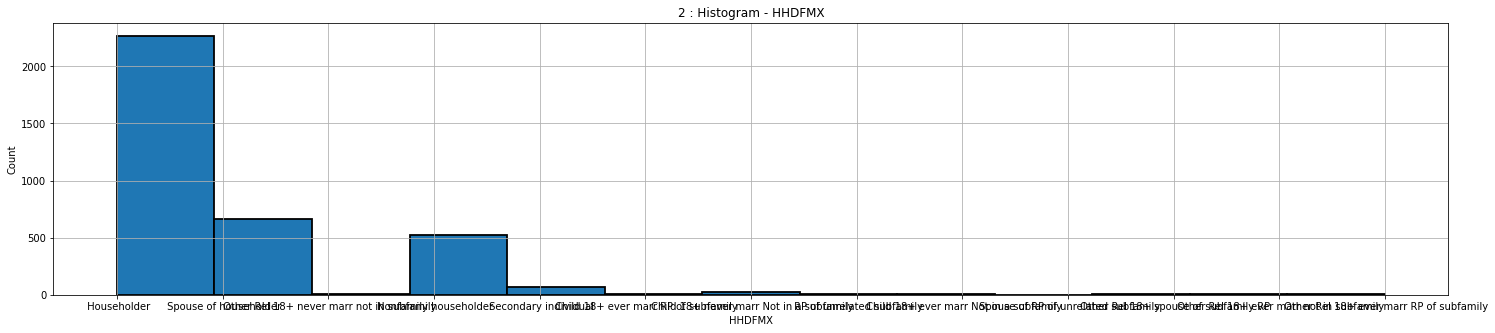

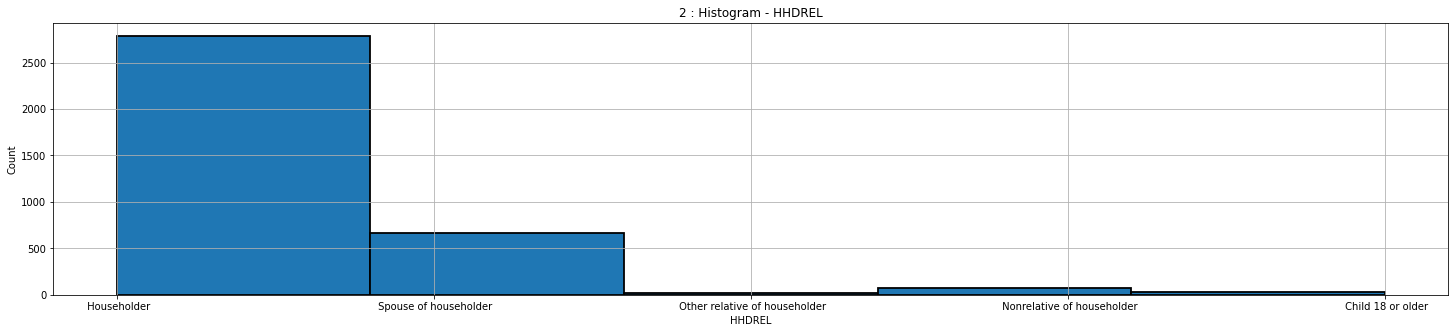

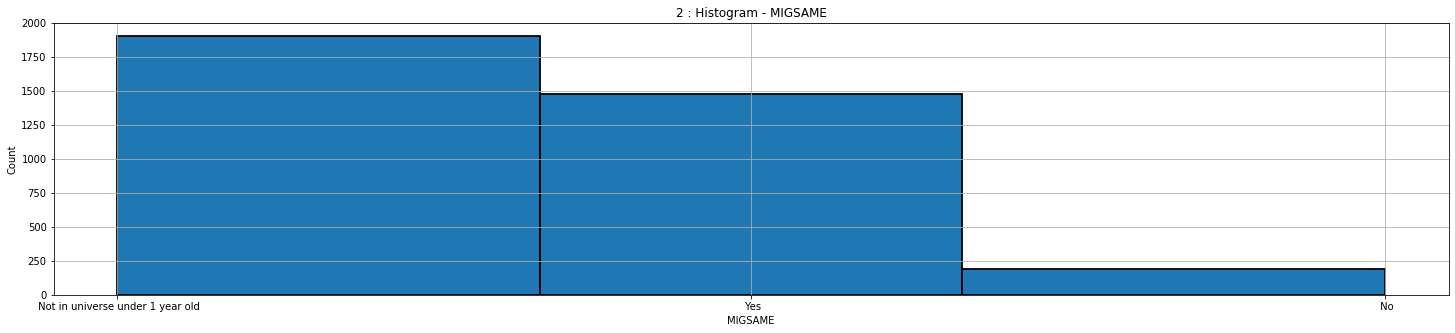

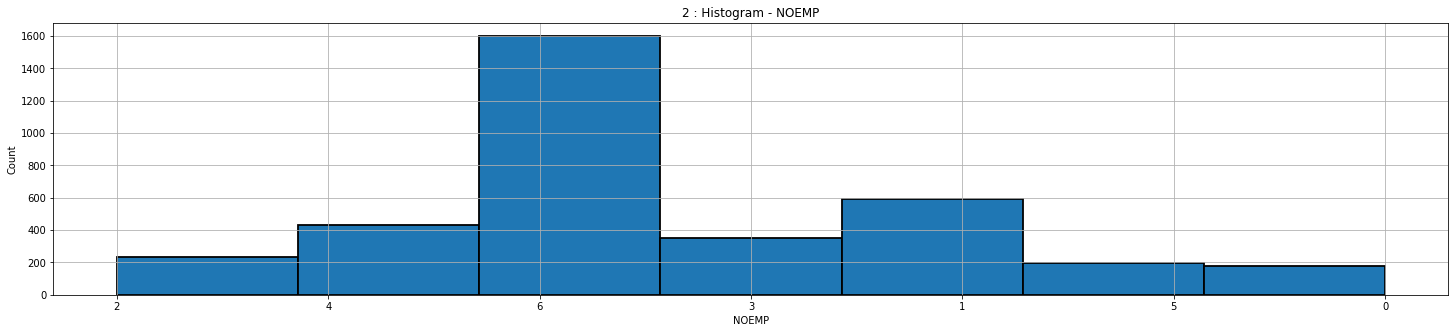

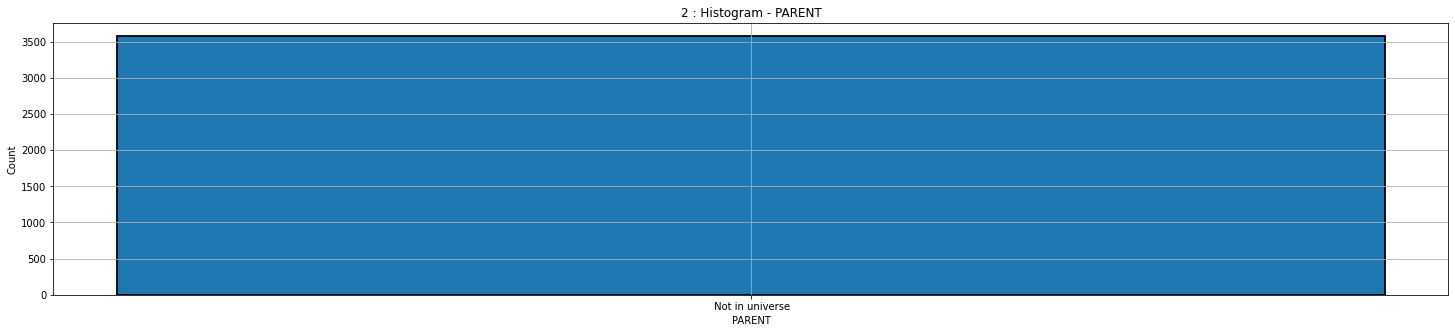

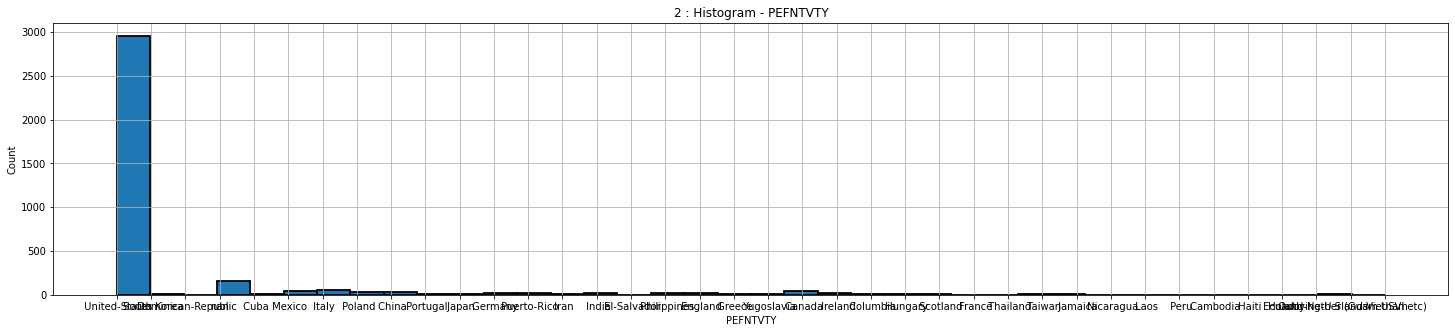

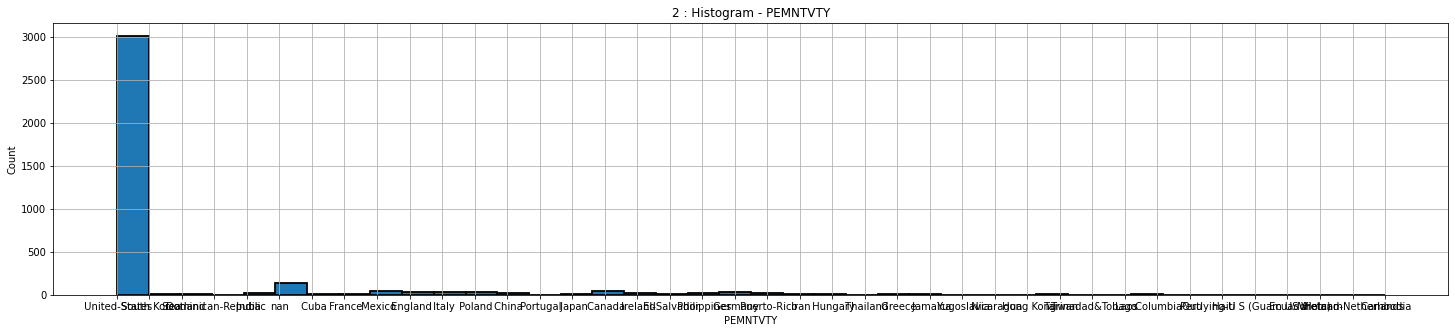

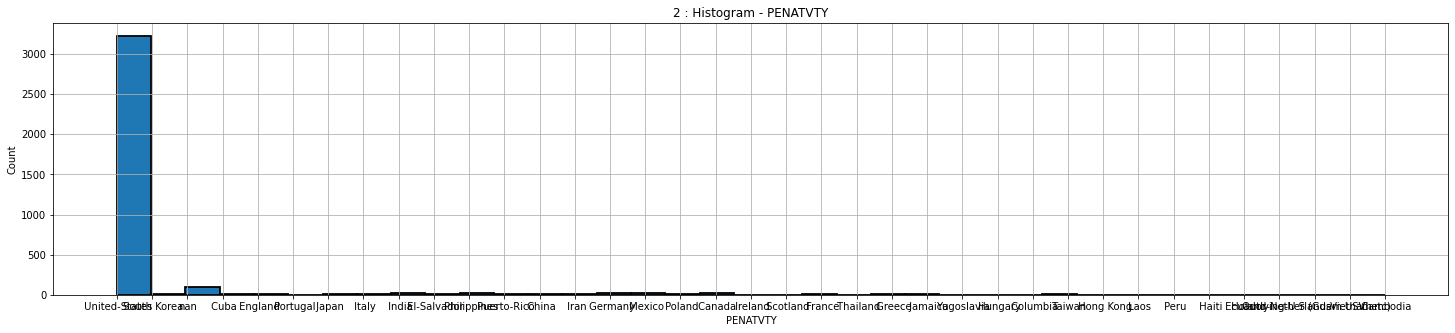

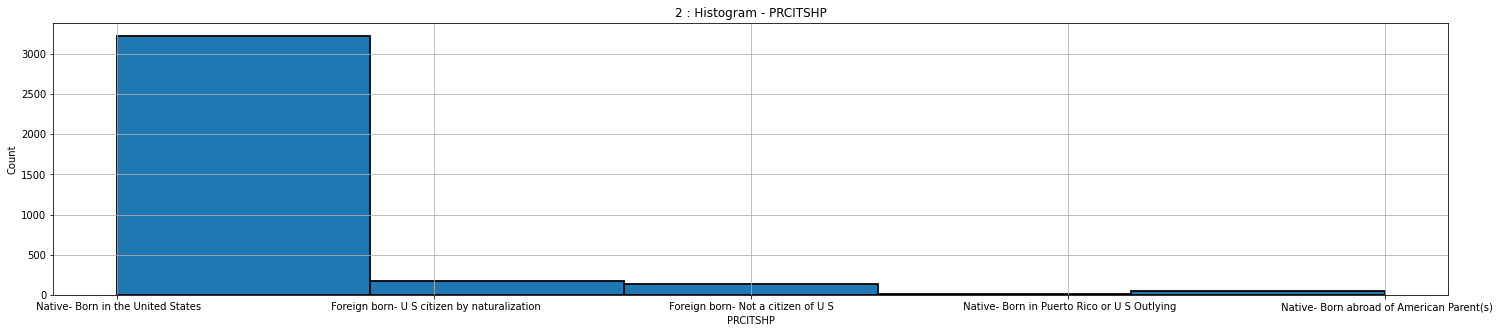

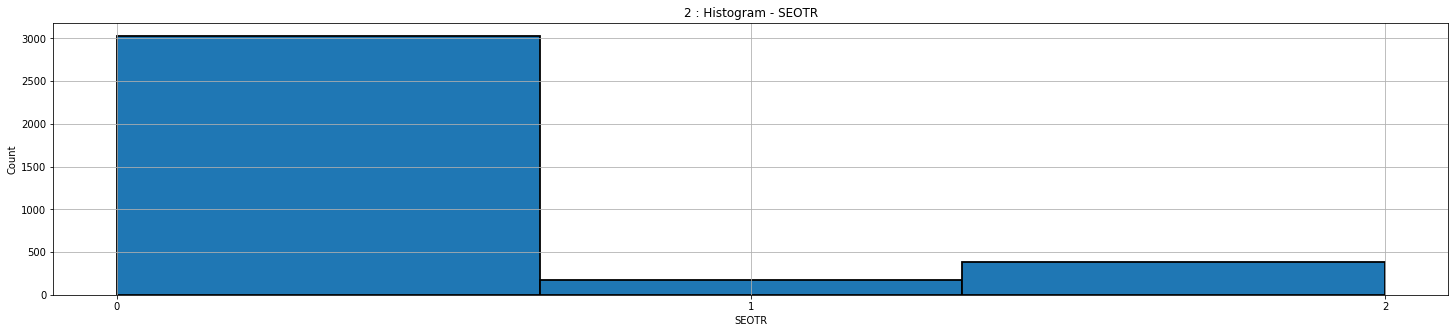

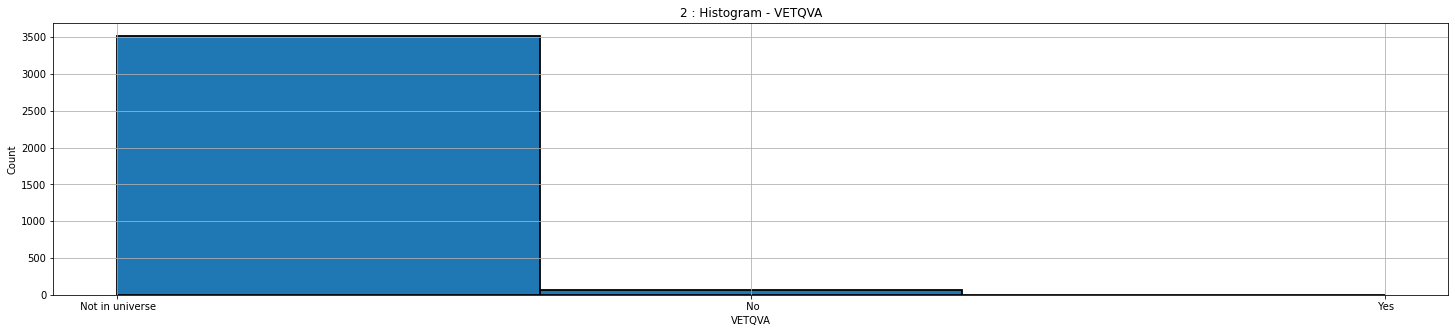

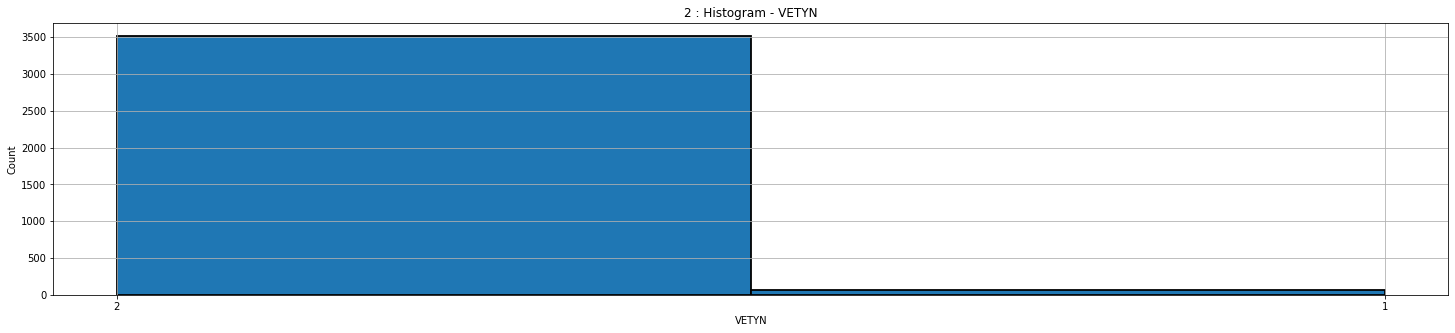

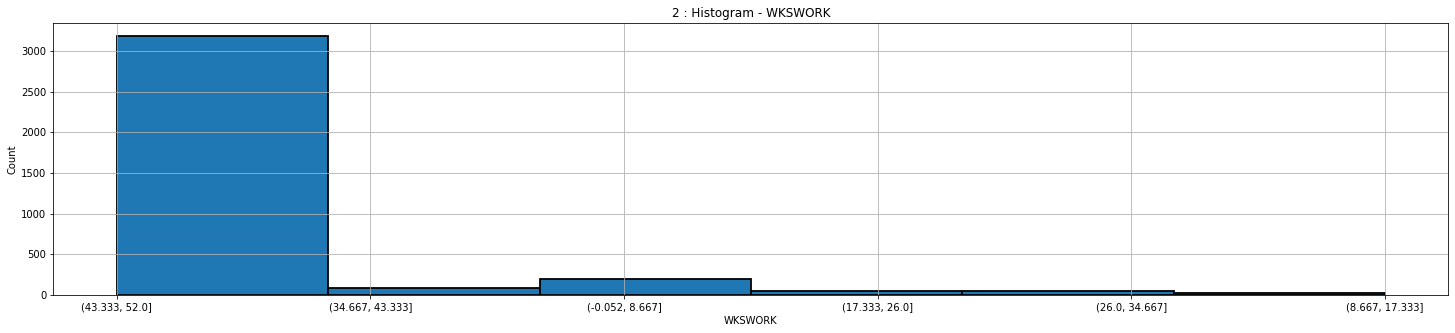

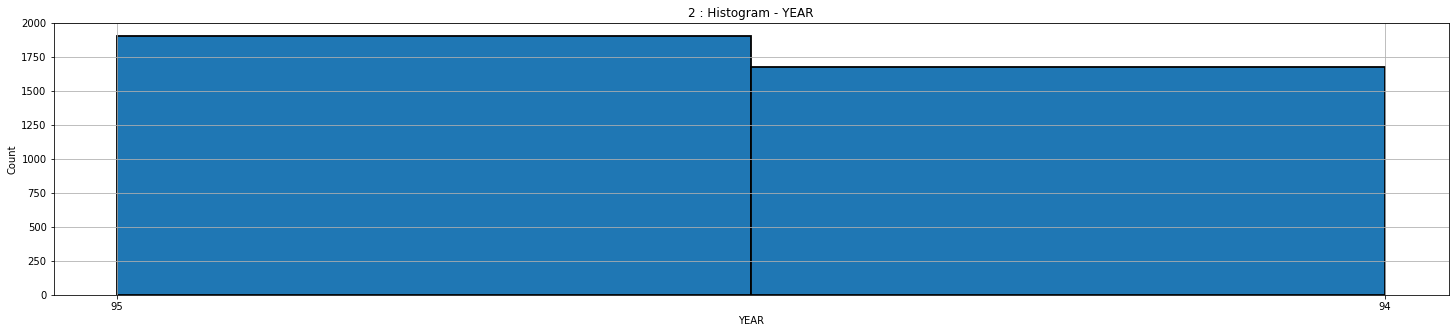

In [8]:
#performing step-2 on the datasets
data = feature_analysis(data, 1)
data_more_than_50 = feature_analysis(data_more_than_50, 2)

Based on our analysis of the histograms by the naked eye, and also by verifying the dominance of a single value(more than 80% dominance)features(/columns) have been removed from both the datasets. Also note that for the purpose of plotting the histograms, we have divided our numerical columns in both the datasets into 6 equisized bins whose ranges depends on the minimum and maximum values present in that column. From the first dataset(population.csv) the following columns have been removed: ['AHRSPAY', 'AHSCOL', 'ARACE', 'AREORGN', 'AUNMEM', 'AUNTYPE', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'GRINREG', 'GRINST', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA']. From the other dataset(more_than_50k.csv), the following columns have been removed: ['AHRSPAY', 'AHSCOL', 'ARACE', 'AREORGN', 'AUNMEM', 'AUNTYPE', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'GRINREG', 'GRINST', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK']. With this we complete our feature analysis part.

Step 3: Imputation, Bucketization, One-Hot-Encoding

In [9]:
def column_modifications(df):
    '''
        Input : dataFrame on which step-3 is applied
    '''

    #3.1
    column_modes = df.mode() #calculate the mode for all columns
    data_cols = df.columns #to get all columns in the dataframe
    numeric_columns = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'WKSWORK'] #specify the numeric columns

    #Through this loop we check that if there is missing data(NaN value) in any column, we replace that by the mode for that column
    for col in data_cols:
        missing_vals = df[col].isna().sum() #calculate number of NaNs in the column
        if(missing_vals > 0): #if number of NaNs > 0, replace them by the mode of the column
            df[col] = df[col].fillna(column_modes[col][0])
    
    #3.2
    #Through this loop we bucketize numeric columns.
    for col in df.columns:
        if(col in numeric_columns):
            df[col] = pd.cut(x=df[col], bins=6) #we cut each numeric column into six equal sized bins
    
    #3.3
    one_hot_encoded = pd.get_dummies(df, columns=list(df.columns)) #one=hot encoding of the dataset finally done.
    df = one_hot_encoded
    return df        


In [10]:
#Perform step-3 on the datasets
data = column_modifications(data)
# print(data.shape)
data_more_than_50 = column_modifications(data_more_than_50)

In this step-3, first we iterate over all the columns present in the dataset and check that if any column contains a NaN value (corresponds to missing data), we replace that by the mode for that column. Then after this mode-replacement step, we bucketize the numerical features. We take 6 bins(/buckets) and perform binning(/bucketization) on the numerical data. This step basically creates 6 equisized ranges for each numeric column and buckets the numerical data into those bins. Post this step, we can say that our numerical data has been converted to categorical values (the 6 bins). After this step, we will finally perform one-hot-encoding on all the columns (since all of them are cateogorial now post-bucketization). We do this set of all these steps on both the datasets.

Dimensionality Reduction : PCA

Now since, the dimensions of the datasets are very high after one hot encoding, so to reduce our training time we do a tradeoff with number of features. Basically we use PCA(Principal component Analysis) to perform dimensionality reduction on the dataset. We fit the PCA and plot the cumulative explained variance vs the number of components. Then using our analysis we will try to determine appropriate number of components to use.

In [11]:
def performPCA(df, anum):
    '''
        Input: dataframe of some higher dimensions on which we perform PCA. anum - Just denotes the dataset number (1 or 2).
        Returns: the fitted PCA instance, cumulative explained variance ratio (array-like)
    '''
    pca = PCA() 
    pca.fit(np.array(df)) #fit the PCA using the passed data
    exp_var_rat = pca.explained_variance_ratio_
    cum_exp_var_perc = np.cumsum(exp_var_rat) #calculate the cumulative explained variance ratio
    plt.plot(cum_exp_var_perc) #plot the same
    plt.xlabel('Cumulative explained variance')
    plt.ylabel('Number of components')
    plt.title(f'PCA Analysis - {anum}')
    plt.savefig(f'./Plots/PCA/pca_plot_{anum}.png', facecolor='white', bbox_inches='tight')
    plt.show()

    return pca, cum_exp_var_perc


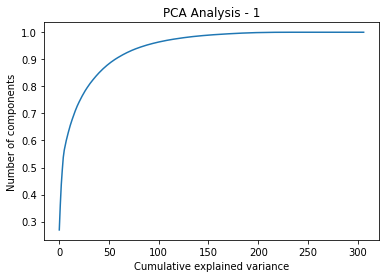

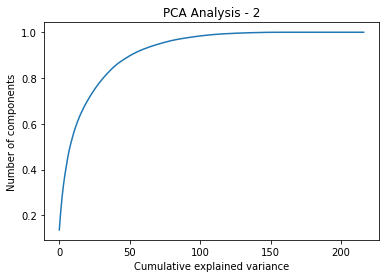

In [12]:
#perform PCA on both the datasets
pca_1, cum_var_1 = performPCA(data, 1)
pca_2, cum_var_2 = performPCA(data_more_than_50, 2)

In [13]:
#From the graphs, we can see that at around number of components equal to 40, both of them have cumulative explained variance ratio greater than 0.85 (85%).
print(cum_var_2[40])   
print(cum_var_1[40])

0.8554270471419653
0.8502779643518565


From the graphs, we can see that at around number of components equal to 40, both of them have cumulative explained variance ratio greater than 0.85 (85%). Selecting the final number of components as 40 based on analysis of the PCA, we finally fit the PCA using n_components=40 and reduce the dimensionality of both the datasets. Finally we fit both the datasets on the PCA instances with n_components=40 to perform dimensionality reduction

In [14]:
#fitting the PCA on the dataset-1 using n_components=40
pca_final_1 = PCA(n_components=40)
dim_reduced_data_1 = pca_final_1.fit_transform(np.array(data))

#fitting the PCA on the dataset-2 using n_components=40
pca_final_2 = PCA(n_components=40)
dim_reduced_data_2 = pca_final_2.fit_transform(np.array(data_more_than_50))

After this step, we can see that both of our datasets have been reduced to 40 dimensions.

In [15]:
#Printing the final dimensions of the dimensionally reduced data using PCA
print(f' 1 - {dim_reduced_data_1.shape}')
print(f' 2 - {dim_reduced_data_2.shape}')

 1 - (199523, 40)
 2 - (3580, 40)


Part 4: Clustering

Here firstly,, we will cluster the data of the general population(population.csv). We vary the number of clusters in the range [10,24] and plot the average within cluster distance vs number of components graph using the same.

In [16]:
num_samples_1 = data.shape[0]
num_samples_2 = data_more_than_50.shape[0]
print(num_samples_1, num_samples_2)

199523 3580


Normal population data

In [17]:
#4.1 Performing K median clustering over 
avg_cluster_distance_1 = {} #this is a dictionary to store the average within cluster distance for all values of 'k' taken
for k_value in tqdm(range(10, 25)): #iterate over values of 'k' i.e in [10,24]
    
    print(f'-------- K VALUE = {k_value} --------')
    random_points_1 = np.array(pd.DataFrame(dim_reduced_data_1).sample(n=k_value)).tolist() #select 'k' random points from the dataset to initialize the centroids
    medians_init_1 = random_points_1 #initialize the centroids
    kmedians_clusterer_1 = kmedians(dim_reduced_data_1, medians_init_1) #create a clustering instance using the given datapoints and the randomly initialized centroids
    kmedians_clusterer_1.process() #perform the clustering

    avg_dist_1 = kmedians_clusterer_1.get_total_wce() / k_value #gets the avg within cluster distance
    avg_cluster_distance_1[k_value] = avg_dist_1
    print(f'average within cluster distance = {avg_dist_1}')

    clusters_1 = kmedians_clusterer_1.get_clusters() #gets the clusters
    medians_1 = kmedians_clusterer_1.get_medians() #gets the centroids


  0%|          | 0/15 [00:00<?, ?it/s]

-------- K VALUE = 10 --------
average within cluster distance = 189438.611414096
-------- K VALUE = 11 --------
average within cluster distance = 139892.52132526276
-------- K VALUE = 12 --------
average within cluster distance = 146563.40996934954
-------- K VALUE = 13 --------
average within cluster distance = 144754.414918958
-------- K VALUE = 14 --------
average within cluster distance = 117558.03876635389
-------- K VALUE = 15 --------
average within cluster distance = 111696.87238364173
-------- K VALUE = 16 --------
average within cluster distance = 102417.85202463735
-------- K VALUE = 17 --------
average within cluster distance = 98821.86799607881
-------- K VALUE = 18 --------
average within cluster distance = 80426.43514369709
-------- K VALUE = 19 --------
average within cluster distance = 81436.48968614406
-------- K VALUE = 20 --------
average within cluster distance = 78263.7477375166
-------- K VALUE = 21 --------
average within cluster distance = 78704.42016697684
--

In [26]:
def plot_clust_dist(avg_clust_distance, anum):
    '''
        This function is used to draw the avg within-cluster distance vs a number of clusters graph.
        Input: a list containing the average within cluster distances for k values in [10,24], anum is just used for referencing the plot while saving.
    '''
    plt.plot([x for x in range(10, 25)], list(avg_clust_distance.values()), marker='o')
    plt.xlabel('No. of clusters')
    plt.ylabel('Average cluster distance')
    plt.title('avg cluster distance vs number of clusters')
    plt.savefig(f'./Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
    plt.show()

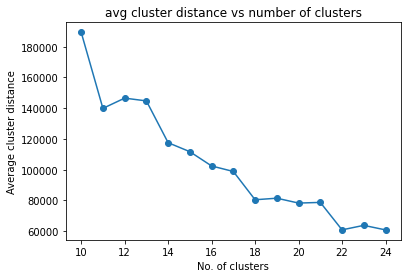

In [30]:
plot_clust_dist(avg_cluster_distance_1, 1) #draw the avg within-cluster distance vs a number of clusters graph.

#4.2

From the graph, we can see that the value of average within cluster distance decreases fairly till number of cluster = 18. After that it almost remains constant for somes values and also we can say that there is not much major decrease post that. So we can choose the value of 'k' as 18 and it represents the elbow.
Now running the clustering for k = 18.

In [20]:
#4.3 Applying k-median clustering with the best value chosen above
selected_k_value = 18 #the selected/chosen/best value
print(f'-------- K VALUE = {selected_k_value} --------')
random_points_sel_1 = np.array(pd.DataFrame(dim_reduced_data_1).sample(n=selected_k_value)).tolist()  #select 'k' random points from the dataset to initialize the centroids
medians_init_sel_1 = random_points_sel_1 #initialize the centroids
kmedians_clusterer_sel_1 = kmedians(dim_reduced_data_1, medians_init_sel_1) #create a clustering instance using the given datapoints and the randomly initialized centroids
kmedians_clusterer_sel_1.process() #perform the clustering

avg_dist_sel_1 = kmedians_clusterer_sel_1.get_total_wce() / selected_k_value #gets the avg within cluster distance
print(f'average within cluster distance = {avg_dist_sel_1}')

clusters_sel_1 = kmedians_clusterer_sel_1.get_clusters() #gets the clusters
medians_sel_1 = kmedians_clusterer_sel_1.get_medians() #gets the centroids

-------- K VALUE = 18 --------
average within cluster distance = 87750.42731537505


In [22]:
print(len(medians_sel_1))

18


Part-5

More Than 50k 

The same data preprocessing, analysis etc steps have been already performed for more_than_50k dataset. Here we will perform clustering on it using the appropriate value of 'k' we have obtained from the Part-4 which is : k = 18.

In [35]:
selected_k_value = 18
print(f'-------- K VALUE = {selected_k_value} --------')
random_points_sel_2 = np.array(pd.DataFrame(dim_reduced_data_2).sample(n=selected_k_value)).tolist()  #select 'k' random points from the dataset to initialize the centroids 
medians_init_sel_2 = random_points_sel_2 #initialize the centroids
kmedians_clusterer_sel_2 = kmedians(dim_reduced_data_2, medians_init_sel_2) #create a clustering instance using the given datapoints and the randomly initialized centroids
kmedians_clusterer_sel_2.process() #perform the clustering

avg_dist_sel_2 = kmedians_clusterer_sel_2.get_total_wce() / selected_k_value #gets the avg within cluster distance
print(f'average within cluster distance = {avg_dist_sel_2}')

clusters_sel_2 = kmedians_clusterer_sel_2.get_clusters() #gets the clusters
medians_sel_2 = kmedians_clusterer_sel_2.get_medians() #gets the centroids

-------- K VALUE = 18 --------
average within cluster distance = 1639.4550114681897


In [37]:
print(len(medians_sel_2))

18


Part - 6 : Comparing more_than_50k data with Population Data

Part 6.1

In [113]:
def plotClusterProportion(clust_prop, k_val, anum, dataset_name):
    '''
        This function is used to plot the proportions of data in each cluster for a particular dataset.
        Input : clust_prop - a dictionary that contains the cluster number as keys and corresponding proportions as values, k_val - value of k used for clustering, anum & dataset are secondary arguments just used for proper referencing while saving plots
    '''
    x_labels = np.array([str(x) for x in range(1, k_val + 1)]) #contains the cluster numbers i.e an array of numbers from 1 to k_val converted to string format.

    #Plotting code
    plt.figure(figsize=(10, 8))
    plt.bar(x_labels, clust_prop.values()) #using bar plots
    plt.xlabel('Cluster Number')
    plt.ylabel('Proportion of data in the cluster')
    plt.title(f'Proportion of data in each Cluster - {dataset_name}')
    plt.savefig(f'./Plots/Part_6/proportions_bar_{anum}', facecolor='white', bbox_inches='tight')
    plt.show()

 --- Cluster proportions for General population ---
    Cluster No. Proportion
0            1   0.058274
1            2   0.099492
2            3   0.078257
3            4   0.069882
4            5   0.038948
5            6   0.048796
6            7   0.043925
7            8   0.026558
8            9   0.035961
9           10   0.064815
10          11   0.118508
11          12   0.047303
12          13   0.017186
13          14   0.071646
14          15   0.017848
15          16   0.071145
16          17   0.055162
17          18   0.036297
-------------------------------------


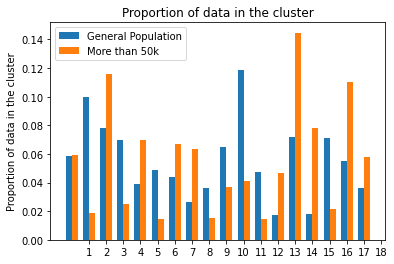

 --- Cluster proportions for More than 50k Data ---
    Cluster No. Proportion
0            1   0.059497
1            2   0.018715
2            3   0.115642
3            4   0.024860
4            5   0.069832
5            6   0.014246
6            7   0.067039
7            8   0.063128
8            9   0.015084
9           10   0.036592
10          11   0.041341
11          12   0.014525
12          13   0.046927
13          14   0.144693
14          15   0.078212
15          16   0.021229
16          17   0.110335
17          18   0.058101
-------------------------------------


In [114]:
#6.1 Comparing the proportion of data in each cluster for the more_than_50k data to the proportion of data in each cluster for the general population.

cluster_population_1 = {} #a dictionary containing the cluster number as key and the no. of datapoints in that cluster as value for General Population data
cluster_population_2 = {} #a dictionary containing the cluster number as key and the no. of datapoints in that cluster as value for More than 50k data
cluster_proportions_1 = {} #a dictionary containing the cluster number as key and proportion of data in that cluster as value for General Population data
cluster_proportions_2 = {} #a dictionary containing the cluster number as key and proportion of data in that cluster as value for More than 50k data

#construct the dictionaries
for i in range(len(clusters_sel_1)):
    cluster_population_1[i + 1] = len(clusters_sel_1[i]) #cluster population of a cluster is simply the number of datapoints in that cluster
    cluster_proportions_1[i + 1] = len(clusters_sel_1[i]) / dim_reduced_data_1.shape[0] #cluster proportion is simply the proportion of data in that cluster i.e no. of data points in that cluster divided by total no. of points in the dataset. Note that here the value of proportion lies betwwen 0 to 1(both inclusive) with 0 representing as no data point in that cluster and 1 representing that all points(100%) of that dataset are present in that particular cluster
for i in range(len(clusters_sel_2)):
    cluster_population_2[i + 1] = len(clusters_sel_2[i]) #cluster population of a cluster is simply the number of datapoints in that cluster
    cluster_proportions_2[i + 1] = len(clusters_sel_2[i]) / dim_reduced_data_2.shape[0] #cluster proportion is simply the proportion of data in that cluster i.e no. of data points in that cluster divided by total no. of points in the dataset. Note that here the value of proportion lies betwwen 0 to 1(both inclusive) with 0 representing as no data point in that cluster and 1 representing that all points(100%) of that dataset are present in that particular cluster
cols_list = ['Cluster No.', 'Proportion']
print(f' --- Cluster proportions for General population ---\n {pd.DataFrame(cluster_proportions_1.items(), columns=[cols_list])}\n-------------------------------------')

labels = [x for x in range(0, 18)]
props1 = list(cluster_proportions_1.values())
props2 = list(cluster_proportions_2.values())
# print(props1)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, props1, width, label='General Population')
rects2 = ax.bar(x + width/2, props2, width, label='More than 50k')
ax.set_ylabel('Proportion of data in the cluster')
ax.set_title('Proportion of data in the cluster')
ax.set_xticks(labels)
ax.legend()
plt.show()
print(f' --- Cluster proportions for More than 50k Data ---\n {pd.DataFrame(cluster_proportions_2.items(), columns=[cols_list])}\n-------------------------------------')



As we can see that the More than 50k dataset, there is more disparity in the cluster proportions distribution as compared to General population dataset. In the general population dataset more number of clusters are at similar values with only a few high peaks(eg cluster 2, 12) which represent clusters with higher proportion in the dataset and a few short bars(eg cluster 13, 15) which represent clusters with lower proportion in the dataset. The variation can be more prominently observed in the More than 50k data wherein the data is unevenly distributed among the clusters with more higher peaks and more shorter bars. So in all, the data seems to be more uniformly distributed in General Population and less uniformly distributed in More than 50k data. The maximum proportion cluster in General Population data has is proportion value 0.118508 [means it constitutes 11.8508% of total general population data] (at cluster no.11 in its clustering) whereas in more than 50k data, the maximum proportion cluster has proportion value 0.144693 [means it constitutes 14.4693% of total general population data] (at cluster no.14). The minimum proportion cluster in General Population data has a proportion value 0.017186 [means it constitutes 1.7186% of total general population data] (at cluster no.13 in its clustering) whereas in more than 50k data, the minimum proportion cluster has proportion value 0.014246 [means it constitutes 1.4246% of total general population data] (at cluster no.6). 

Part 6.2

In [115]:
#6.2 Checking which clusters are over-represented in the general population vs more_than_50k population and vice versa
num_clusters = 18
#i) Finding out what clusters are over represented in general population vs more_than_50k
representation_diff_gvm = np.array(list(cluster_proportions_1.values())) - np.array(list(cluster_proportions_2.values()))
df_rep_gvm = pd.DataFrame([x for x in range(1,num_clusters + 1)], columns=['Cluster'])
df_rep_gvm['rep_diff'] = representation_diff_gvm
df_rep_gvm = df_rep_gvm.sort_values(by=['rep_diff'])
df_rep_gvm
over_represented_general = [df_rep_gvm['Cluster'].iloc[-1], df_rep_gvm['Cluster'].iloc[-2]]

#ii)Vice-Versa: Finding out what clusters are over represented in more_than_50k vs General Population
representation_diff_mvg = np.array(list(cluster_proportions_2.values())) - np.array(list(cluster_proportions_1.values()))
df_rep_mvg = pd.DataFrame([x for x in range(1,num_clusters + 1)], columns=['Cluster'])
df_rep_mvg['rep_diff'] = representation_diff_mvg
df_rep_mvg = df_rep_mvg.sort_values(by=['rep_diff'])
over_represented_more_than_50 = [df_rep_mvg['Cluster'].iloc[-1], df_rep_mvg['Cluster'].iloc[-2]]

print(f'Over Represented Clusters in General Population are {over_represented_general[0]}, {over_represented_general[1]}')
print(f'Over Represented Clusters in more than 50k data are {over_represented_more_than_50[0]}, {over_represented_more_than_50[1]}')


Over Represented Clusters in General Population are 2, 11
Over Represented Clusters in more than 50k data are 14, 15


Part 6.3 + 6.4

In [156]:
def perform_representation_analysis(df, pca_instance, centroids, clusters):
    cols = df.columns
    pc1 = pca_instance.components_[0]
    pca_df = pd.DataFrame(cols, columns=['Column'])
    pca_df['ind'] = [x for x in range(len(cols))]
    pca_df['PC'] = pc1
    pca_df = pca_df.sort_values(by="PC")
    top_3 = [(pca_df['Column'].iloc[-1], pca_df['ind'].iloc[-1]), (pca_df['Column'].iloc[-2], pca_df['ind'].iloc[-2]), (pca_df['Column'].iloc[-3], pca_df['ind'].iloc[-3])]
    centroid_features = {}
    for i in range(len(centroids)):
        centroid = np.array(centroids[i])
        centroid_inverse = pca_instance.inverse_transform(centroid.reshape((1, centroid.shape[0])))
        feats = []
        feats.append([top_3[0][0], centroid_inverse[0][top_3[0][1]]])
        feats.append([top_3[1][0], centroid_inverse[0][top_3[1][1]]])
        feats.append([top_3[2][0], centroid_inverse[0][top_3[2][1]]])
        centroid_features[clusters[i]] = feats
    return centroid_features

In [157]:
perform_representation_analysis(data, pca_final_1, [medians_sel_1[1],medians_sel_1[10]], [2, 11])

{2: [['AMJOCC_ Not in universe', 0.9930696164462718],
  ['ADTOCC_0', 0.9930696164462718],
  ['AMJIND_ Not in universe or children', 0.9930696164462718]],
 11: [['AMJOCC_ Not in universe', 0.9939524636766501],
  ['ADTOCC_0', 0.9939524636766501],
  ['AMJIND_ Not in universe or children', 0.9939524636766501]]}

In [158]:
perform_representation_analysis(data_more_than_50, pca_final_2, [medians_sel_2[13], medians_sel_2[14]], [14, 15])

{14: [['YEAR_94', 0.9931239901022457],
  ['AWKSTAT_ Children or Armed Forces', 0.9984879333505456],
  ['MIGSAME_ Yes', 1.0123824864580053]],
 15: [['YEAR_94', 1.0075625875899183],
  ['AWKSTAT_ Children or Armed Forces', 1.0104278530278452],
  ['MIGSAME_ Yes', 0.9877261996191111]]}